# Rt per provincia

Rt di COVID-19 stimato per le province italiane.

> Max Pierini & [NOTIZIÆ Telegram Channel](https://t.me/notiziae)

***

> NB: gli $R_t$ stimati da EpiDataItalia sono parametrizzati attualmente sui <u>soli nuovi casi</u> riportati al [Dipartimento di Protezione Civile](https://github.com/pcm-dpc/COVID-19) e **non sono sovrapponibili al numero di riproduzione stimato da ISS-EpiCentro** che utilizza lo stesso modello *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) ma con dati aggiuntivi attualmente **non disponibili al pubblico** (il numero di casi sintomatici con data di inizio sintomi, il numero di casi sintomatici importati da un’altra regione o dall’estero). Per info sul modello in uso da ISS-EpiCentro consultare la pagina [FAQ sul calcolo del Rt](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt) di ISS. Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

***

Modelli utilizzati:

- stima di Rt: EpiEstim Cori et al. (ref: [Package ‘EpiEstim’](https://cran.r-project.org/web/packages/EpiEstim/EpiEstim.pdf), [Cori et al. 2013](https://academic.oup.com/aje/article/178/9/1505/89262))
    - implementato in python e corretto per ignorare incidenze inferiori a una soglia stabilita nella finestra temporale scelta. Finestra 14 giorni, soglia minima 50 nuovi casi, (vedi [Stima Rt e previsioni](https://www.epidata.it/Italia/stime_Rt.html))
su finestra temporale scelta di 14 giorni
- Distribuzione di intervallo di generazione Cereda-Tirani et al. (ref: [Cereda-Tirani 2020](arXiv:2003.09320))

***

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import seaborn as sns
import matplotlib.pyplot as plt

import json
from matplotlib.lines import Line2D
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

sns.set()

In [2]:
SI_sh_ISS = 1.87
SI_ra_ISS = 0.28

In [3]:
def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

In [4]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        lambda_sum = np.sum(_lambda[t_start[t]:t_end[t]+1])
        if t_end[t] > final_mean_si and incid_sum > 50:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + lambda_sum)
        else:
            a_posterior[t] = .01
            b_posterior[t] = 1
    return a_posterior, b_posterior, lambda_sum

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=True,
                 plot_SI=False,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - CI) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    SI_mu = SI_dist.stats(moments='m')
    SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_y = SI_dist.pdf(SI_x)
    # pad SI with zeros
    SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2
    b_prior = (sd_prior ** 2) / mu_prior
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior, lambda_sum = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:    
        ax = res.plot(
            y='R', color='w', alpha=.75, lw=1, figsize=(12, 5), title=title, ylim=(0, 5)
        )

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior<1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior<1, quantile_lo_posterior, 1), 
            alpha=1, color='C2', label='lower than 1')

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior>1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior>1, quantile_lo_posterior, 1), 
            alpha=1, color='C3', label='higher than 1')

        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method, window {window} days, '+\
                  f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
                  f'C.I. {CI:.0%}',
            ylim=(0, 4),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='upper right')

        ax.axhline(1, color='k', ls='-')
        plt.show()
    
    return res

# Province

In [7]:
def covid_province():
    df = pd.read_csv(
        "https://github.com/pcm-dpc/COVID-19/raw/master/dati-province/dpc-covid19-ita-province.csv",
        parse_dates=['data']
    ).sort_values(by='data')
    df['data'] = df.data.dt.normalize()
    return df

In [8]:
pro = covid_province()

In [9]:
pro.dropna(subset=['sigla_provincia'], inplace=True)

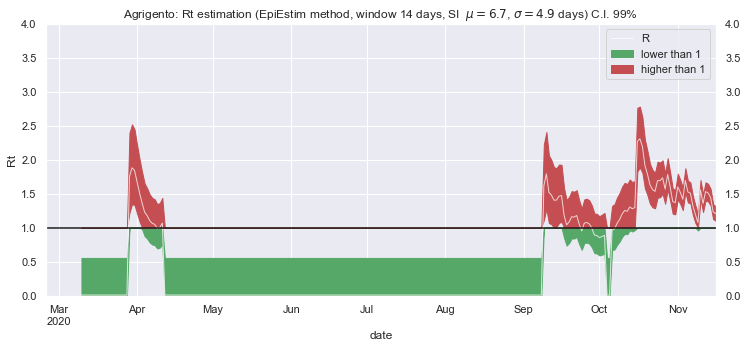

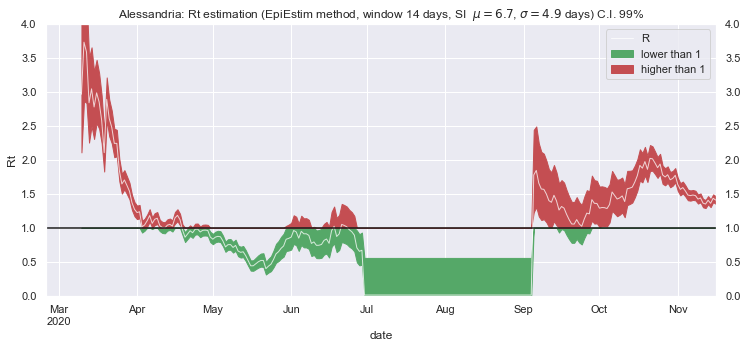

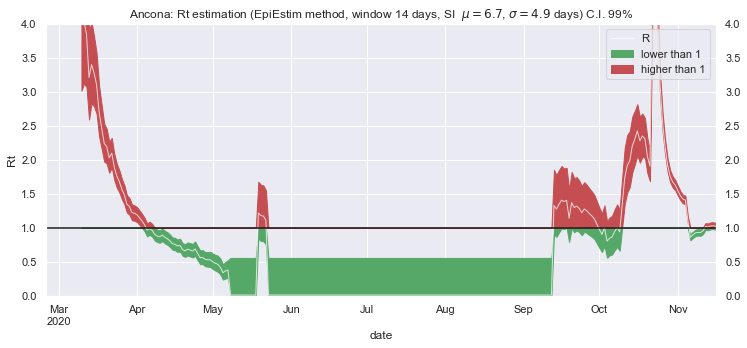

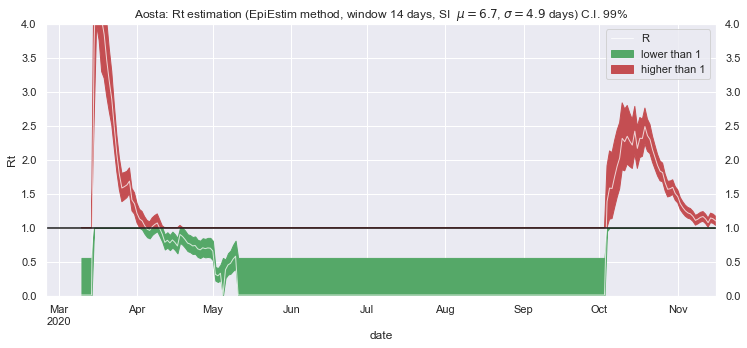

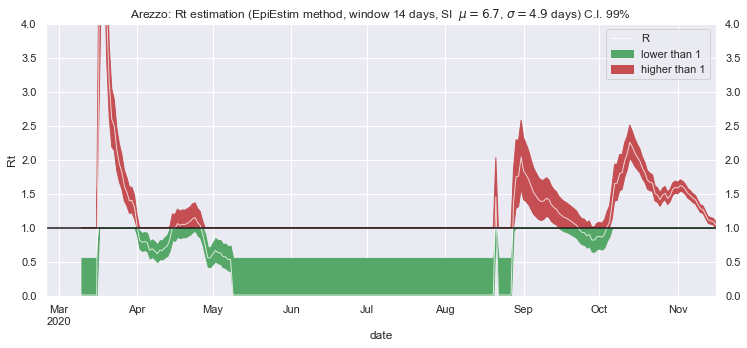

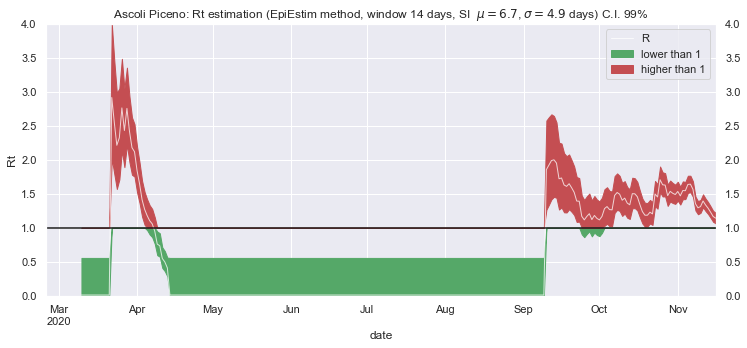

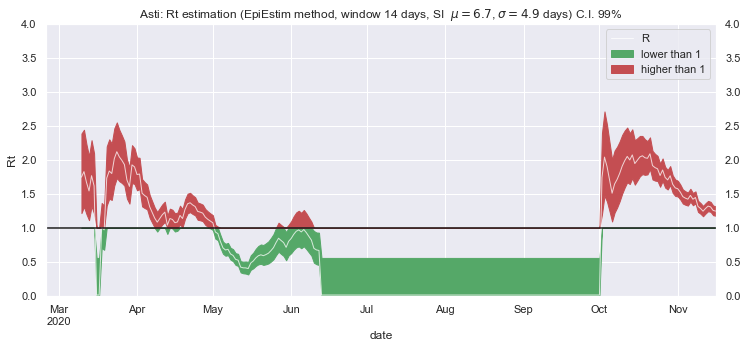

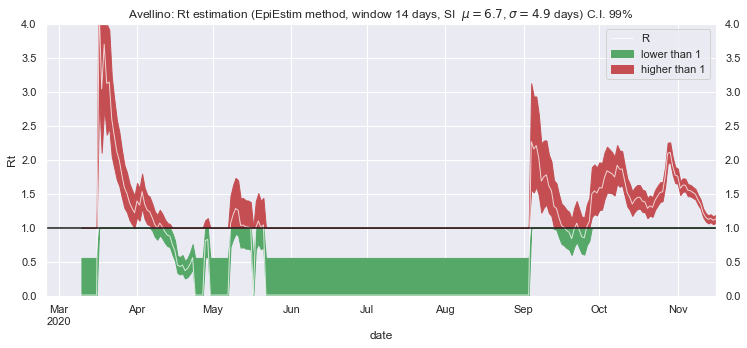

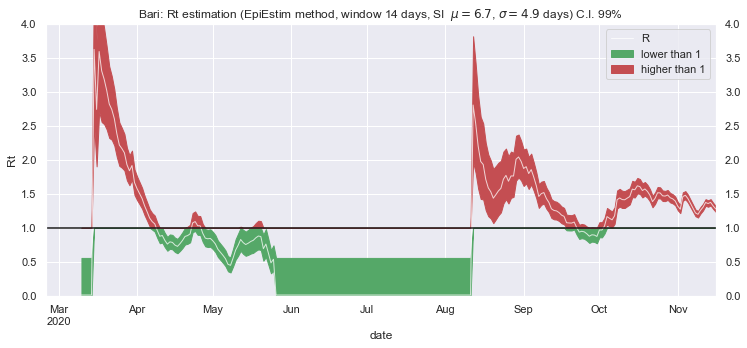

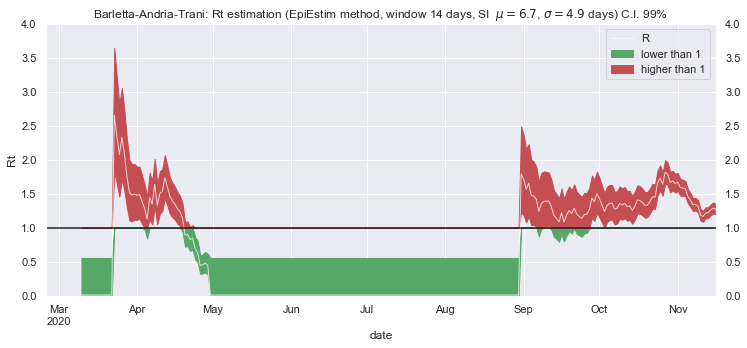

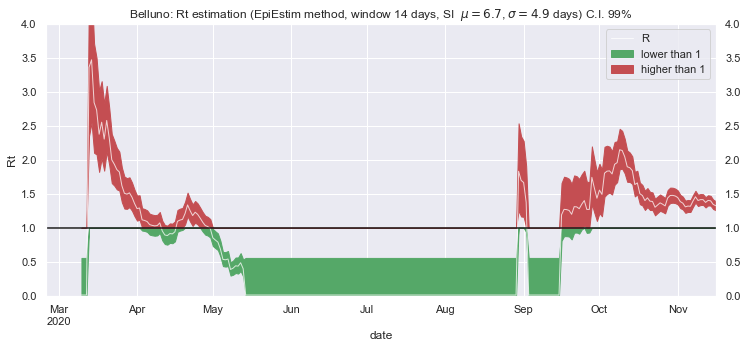

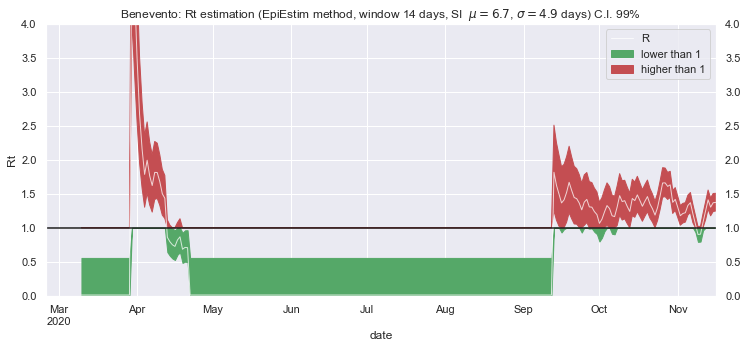

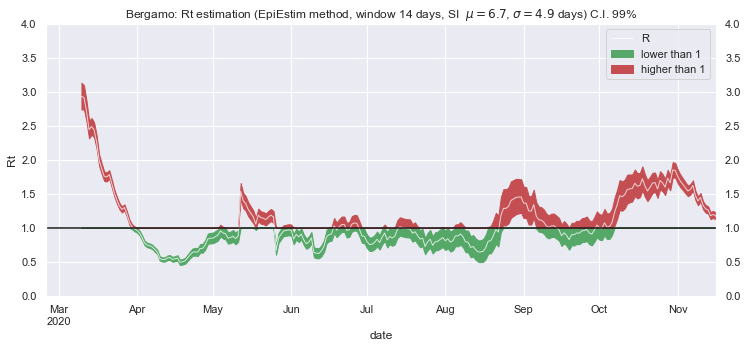

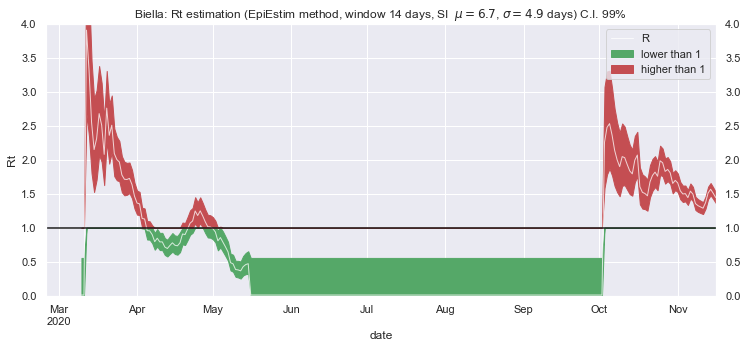

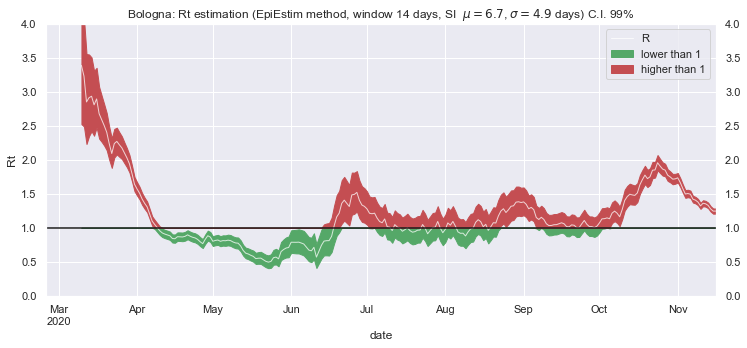

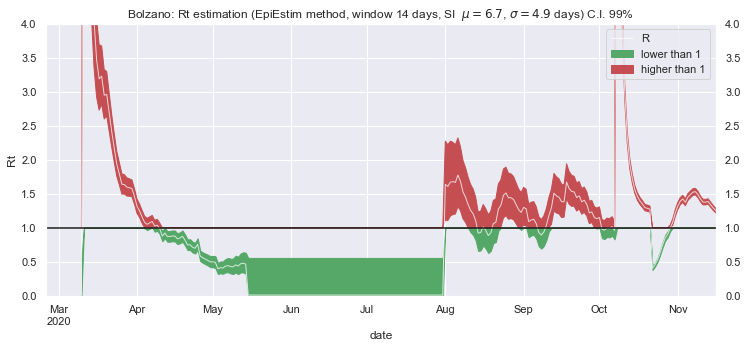

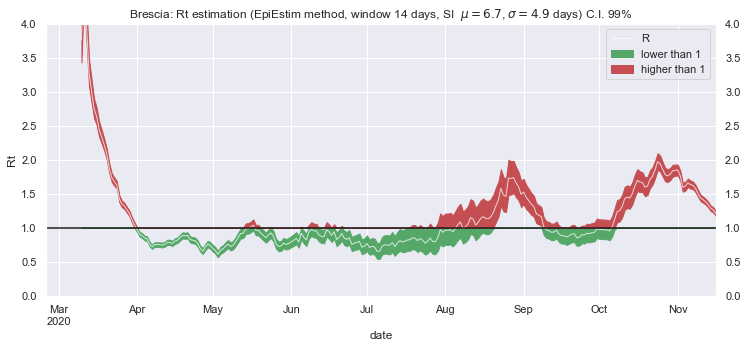

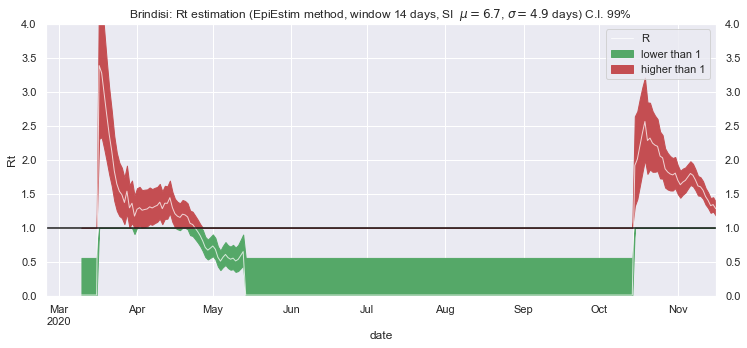

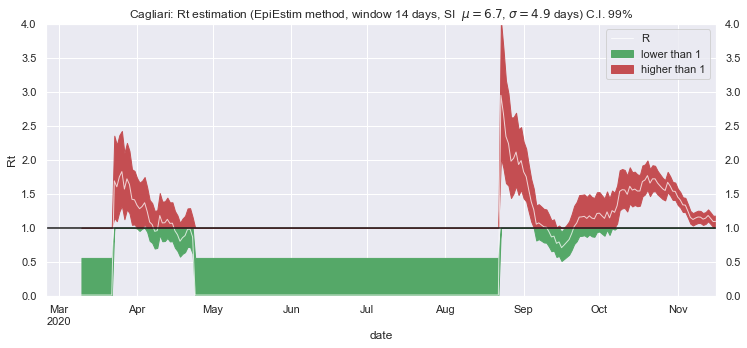

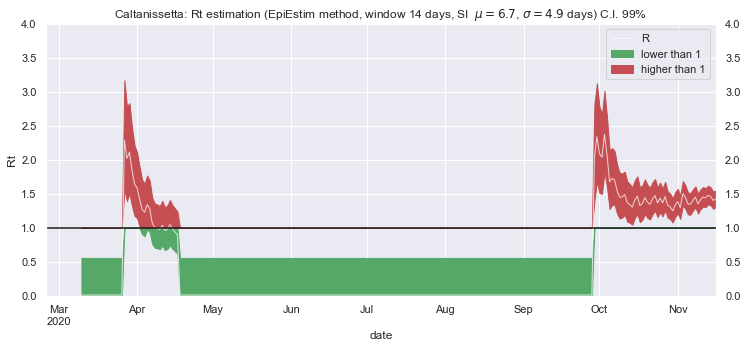

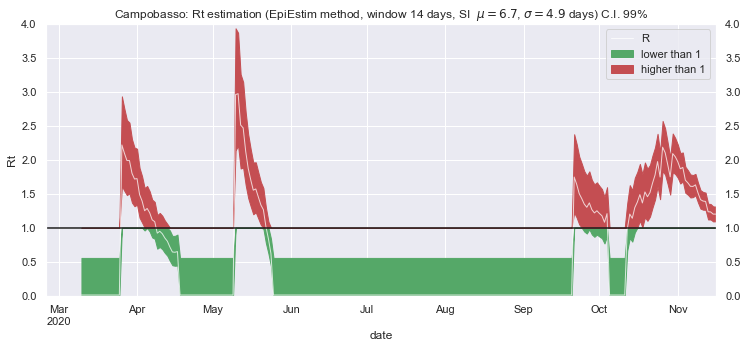

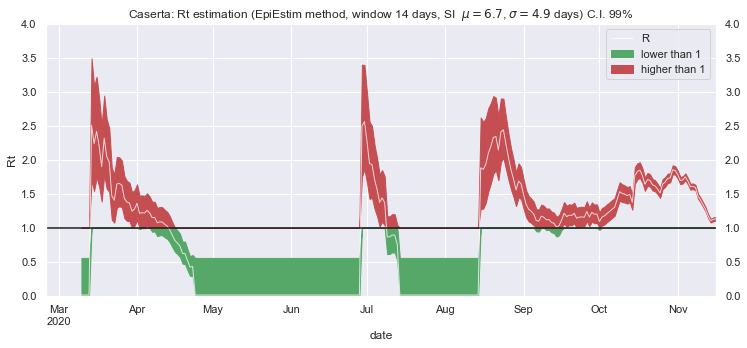

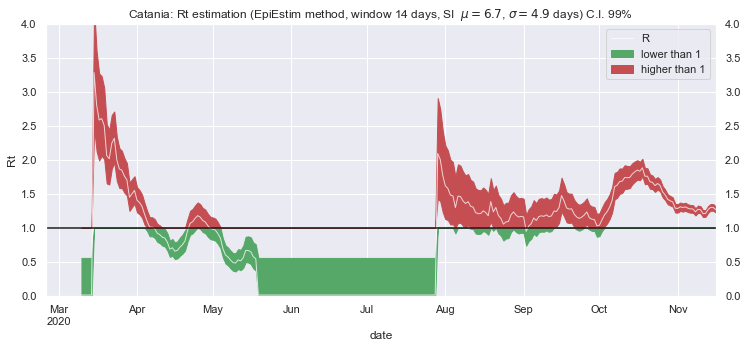

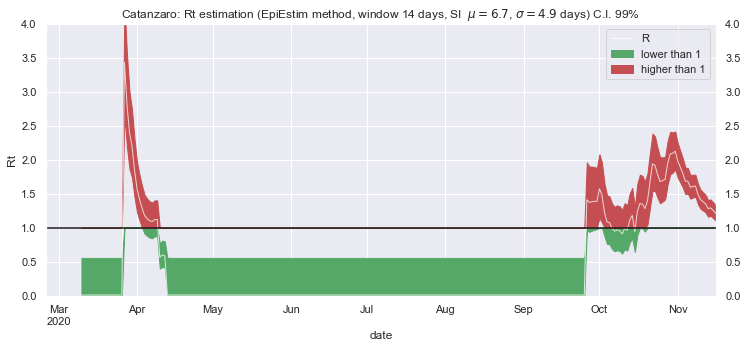

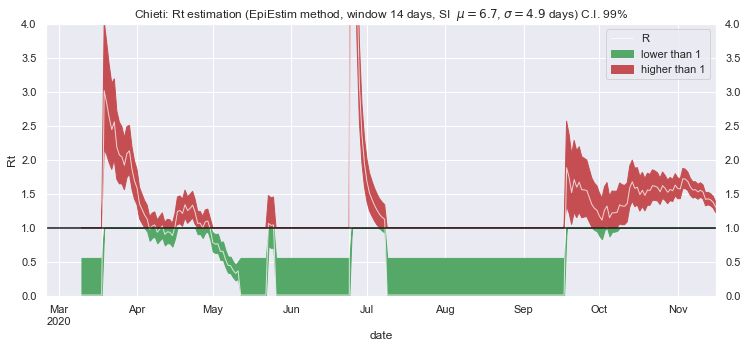

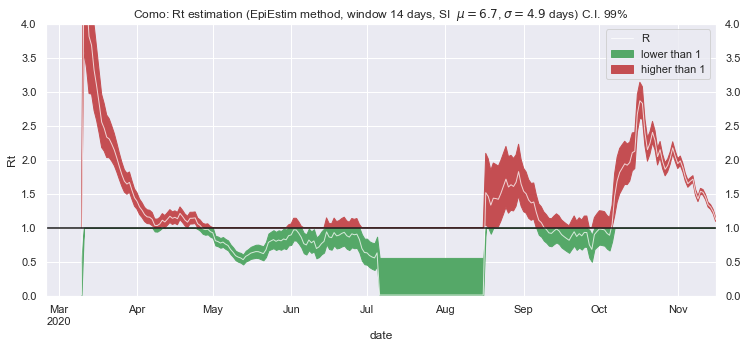

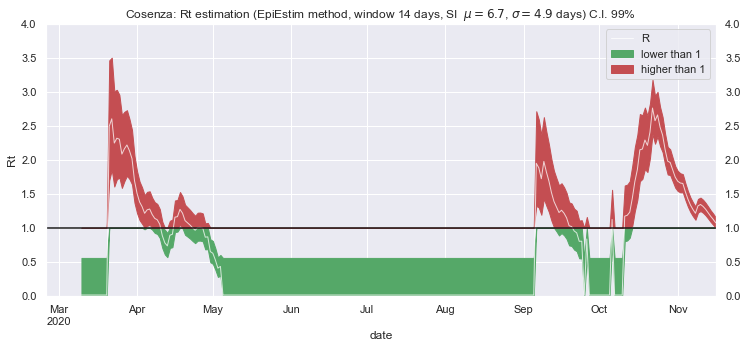

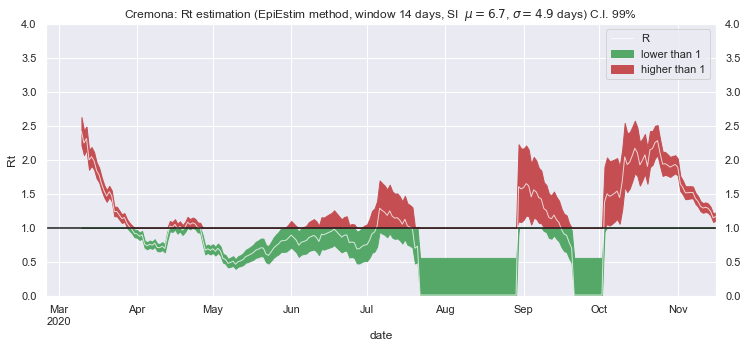

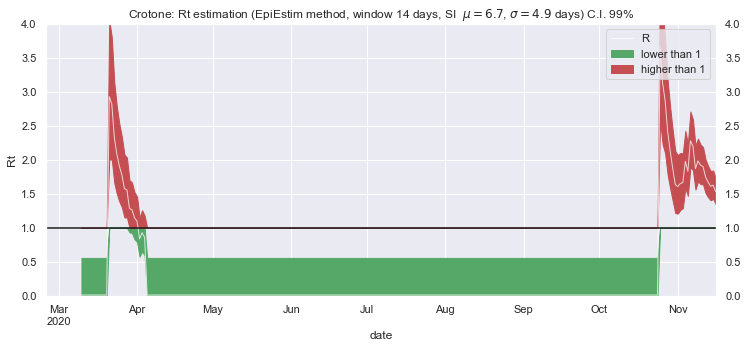

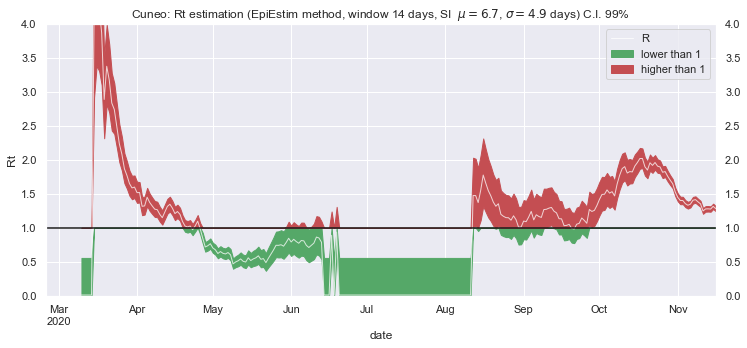

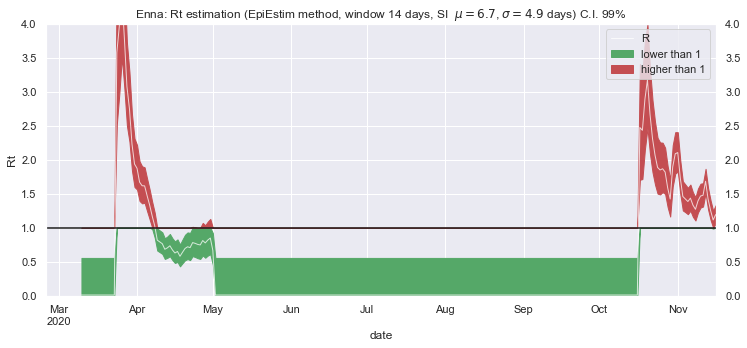

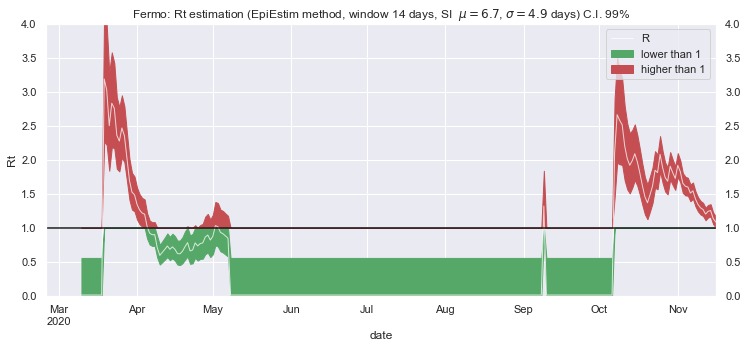

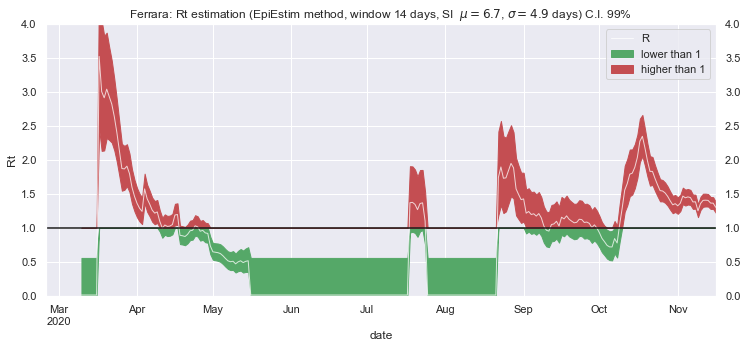

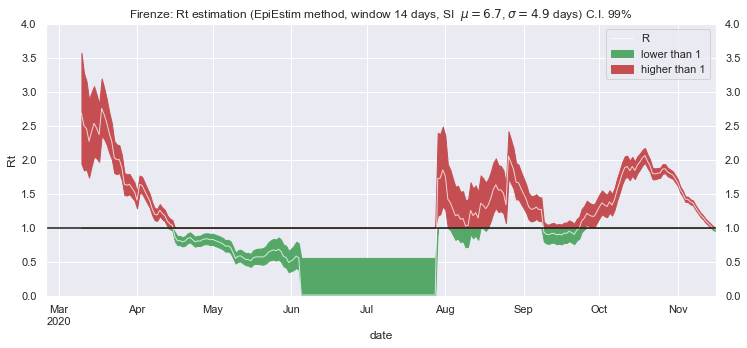

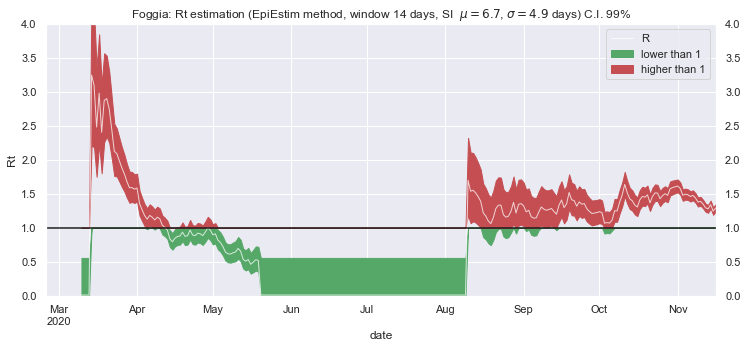

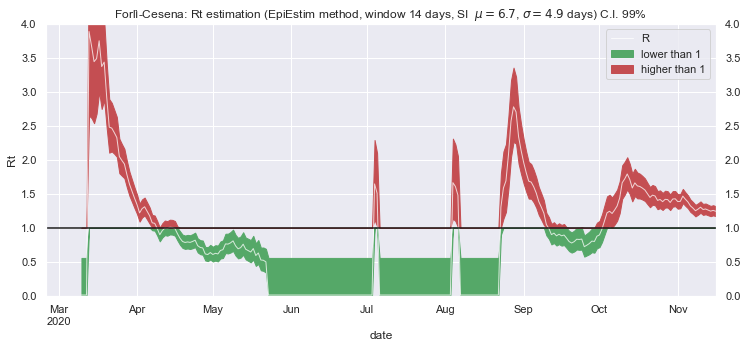

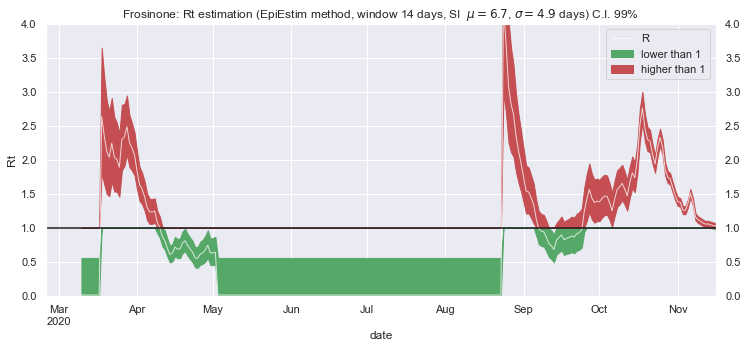

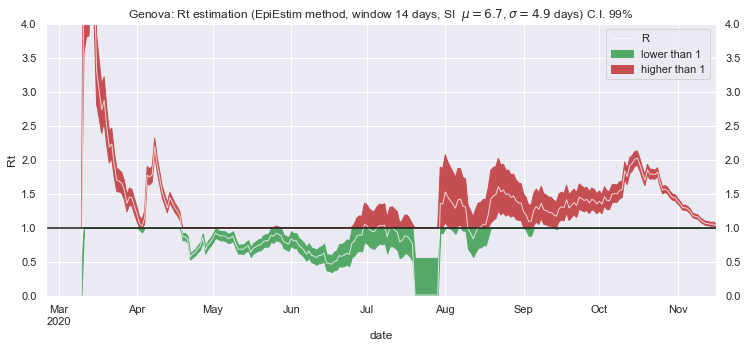

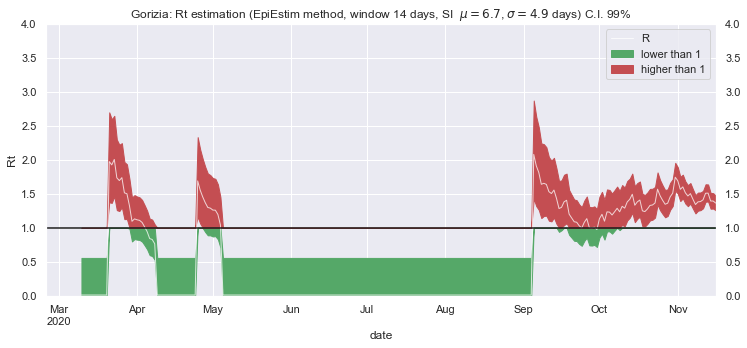

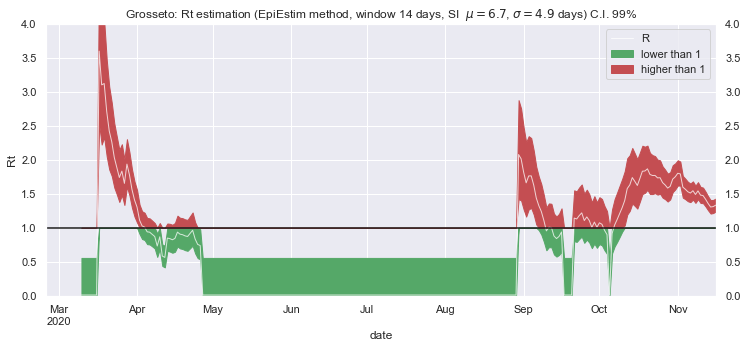

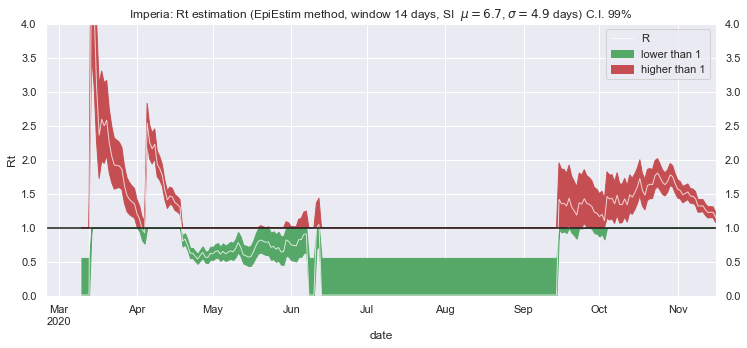

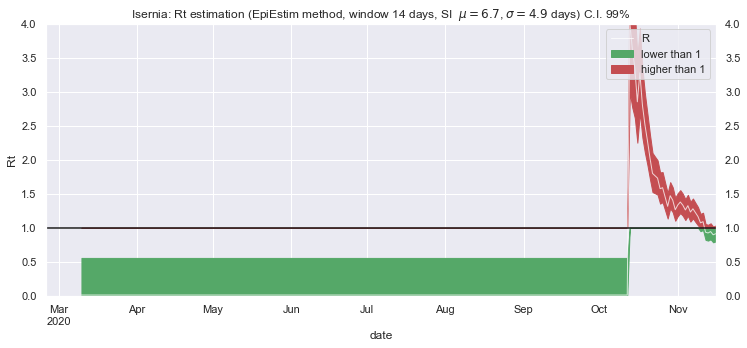

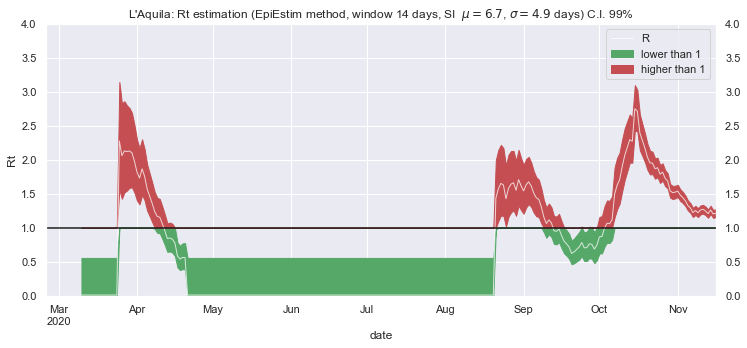

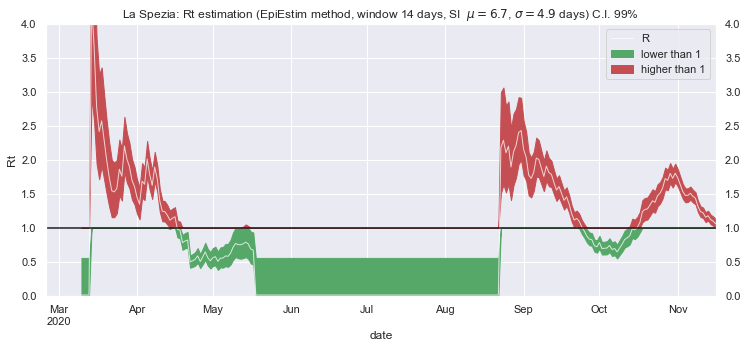

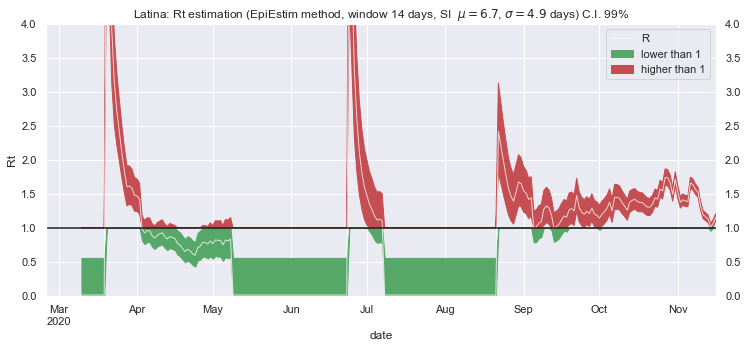

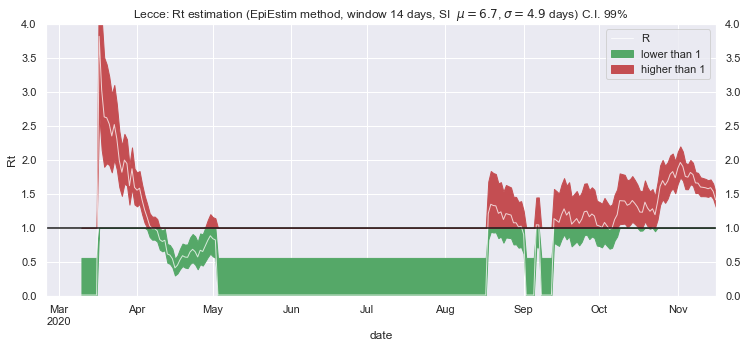

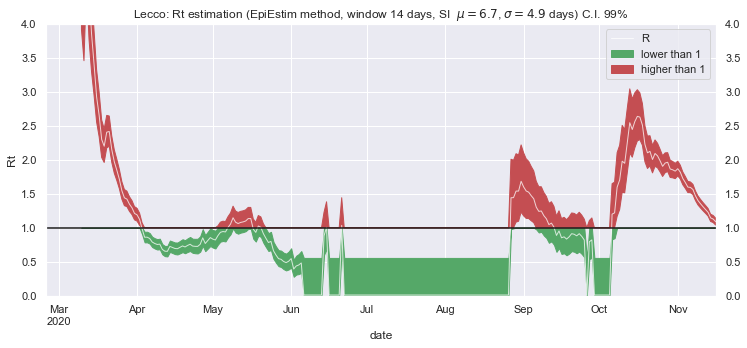

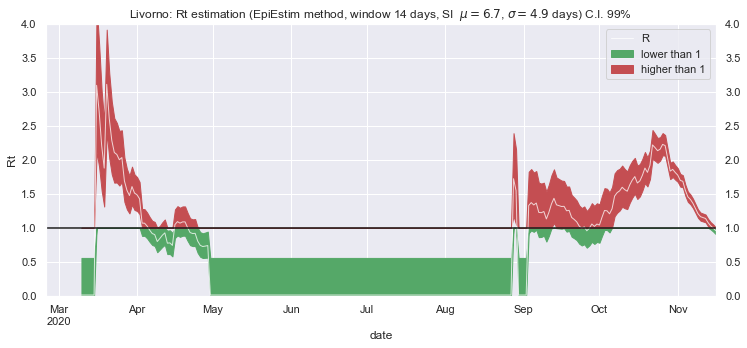

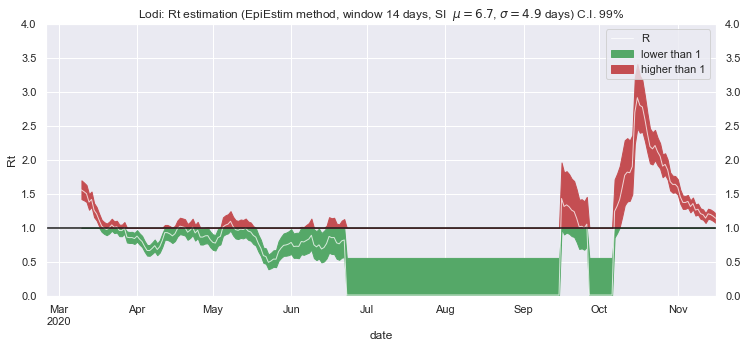

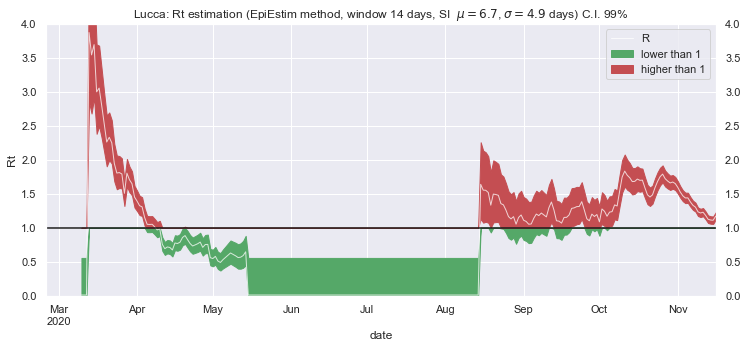

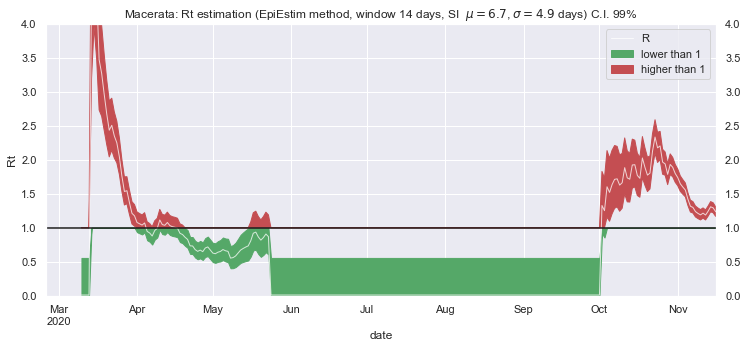

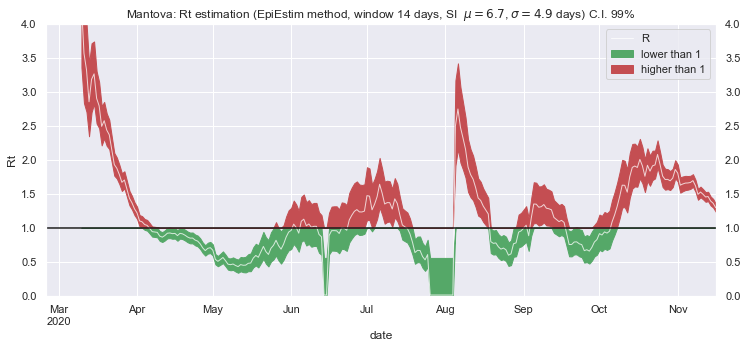

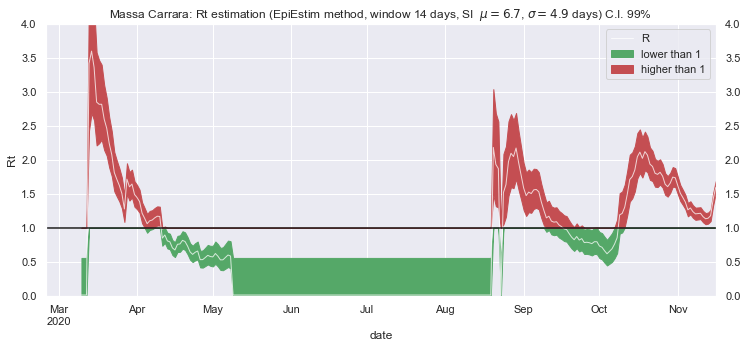

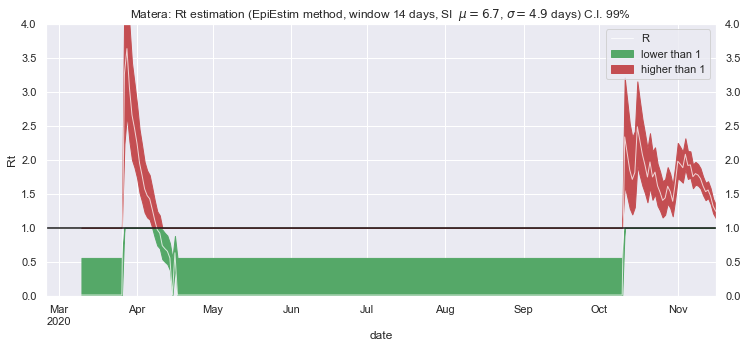

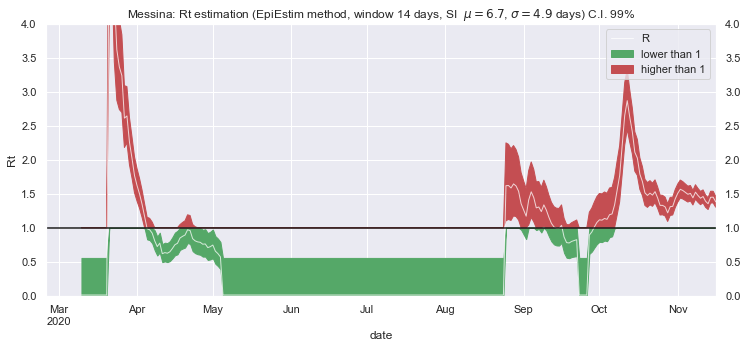

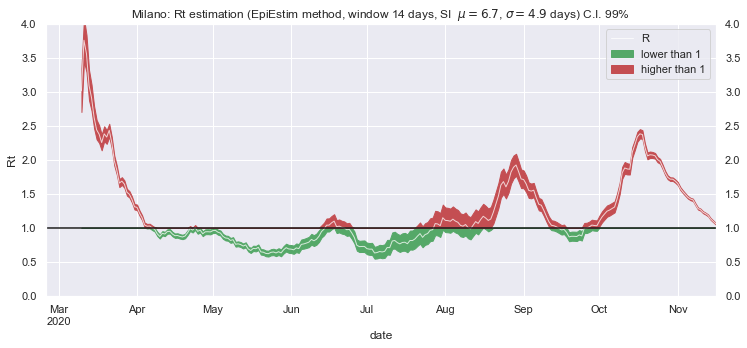

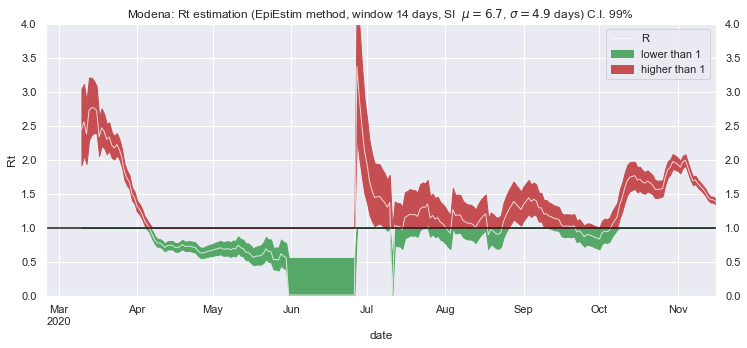

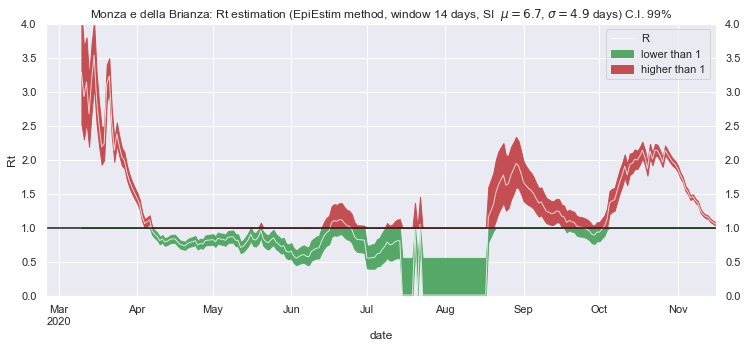

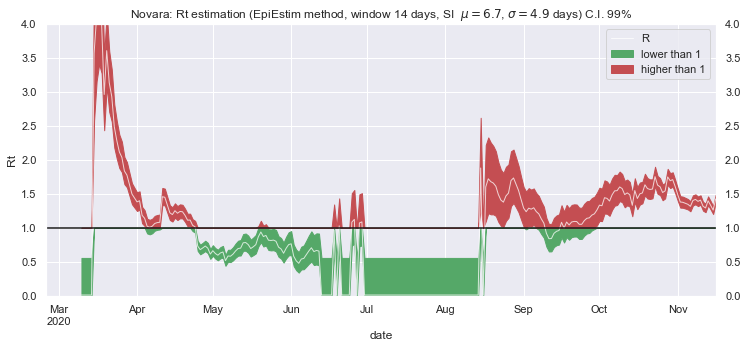

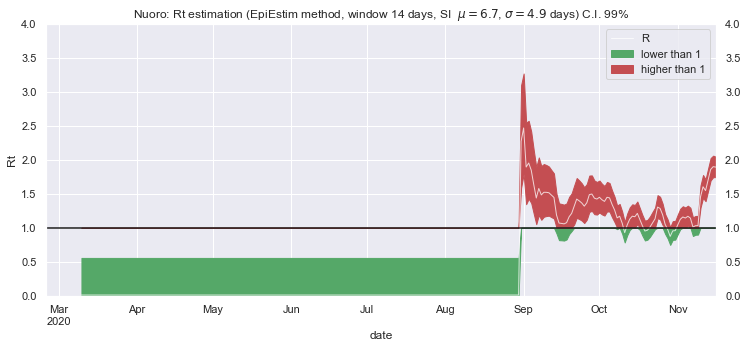

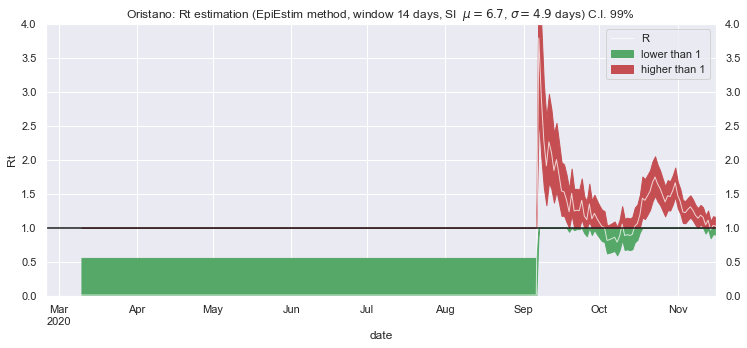

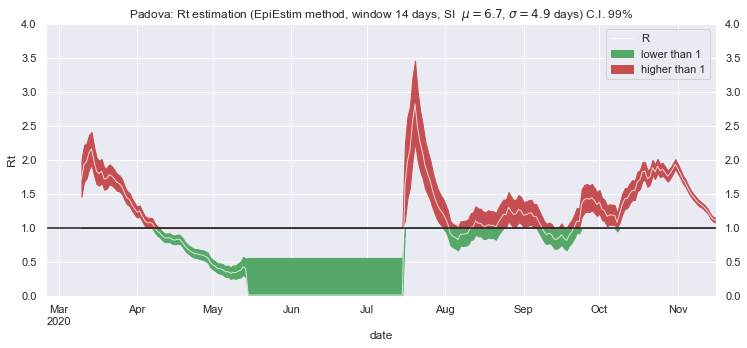

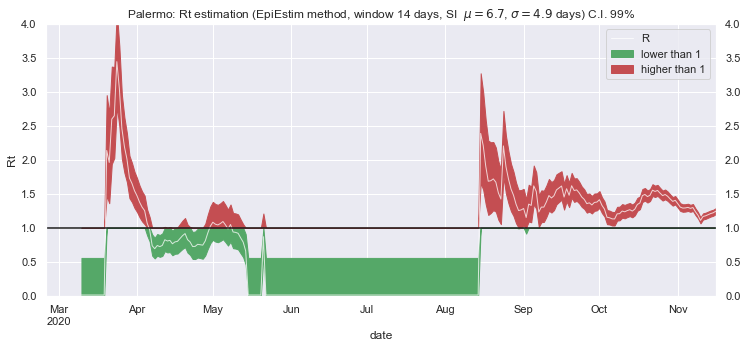

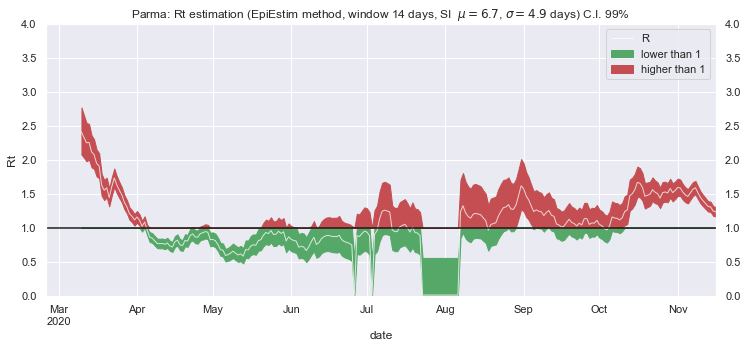

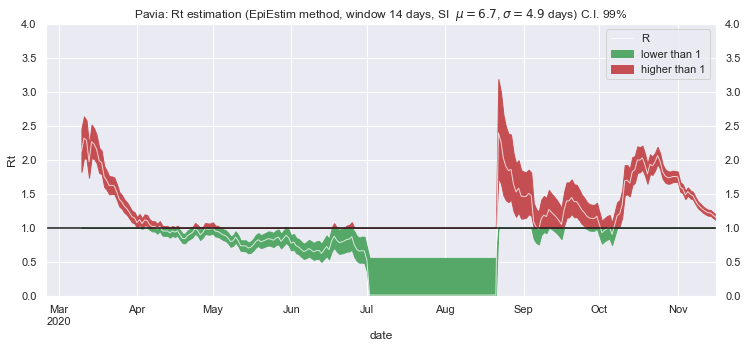

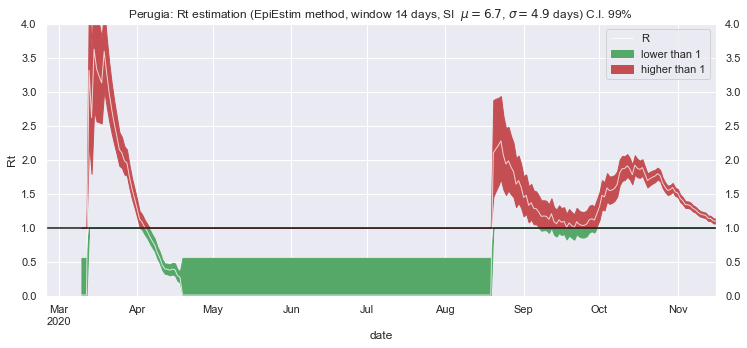

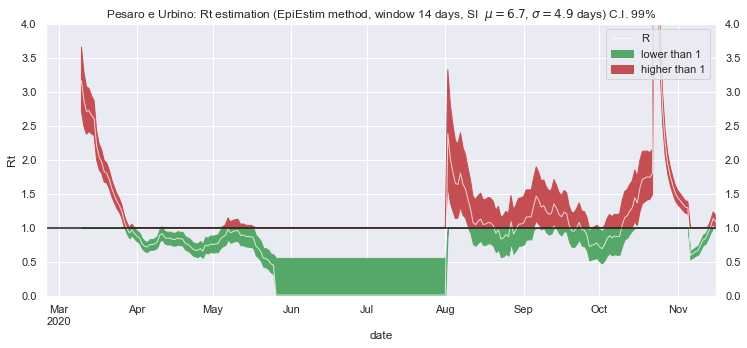

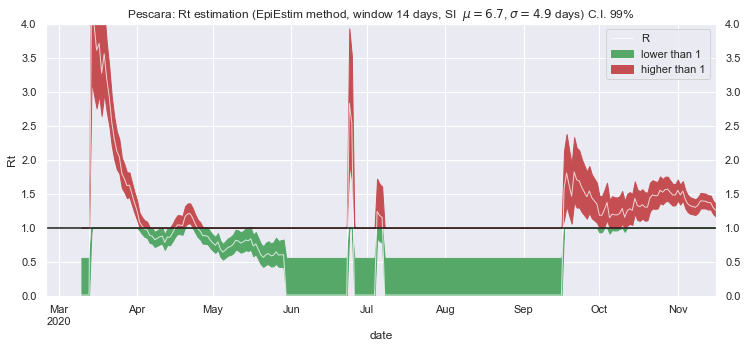

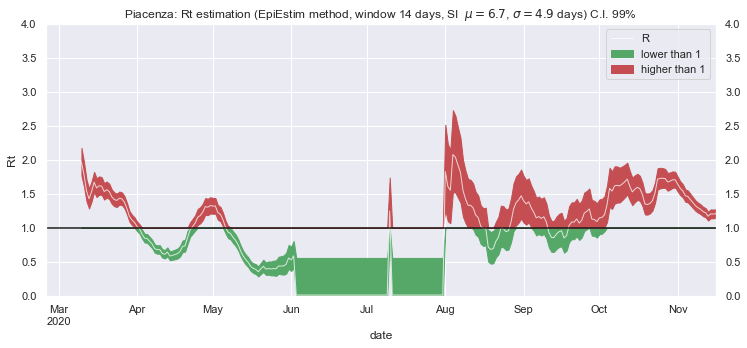

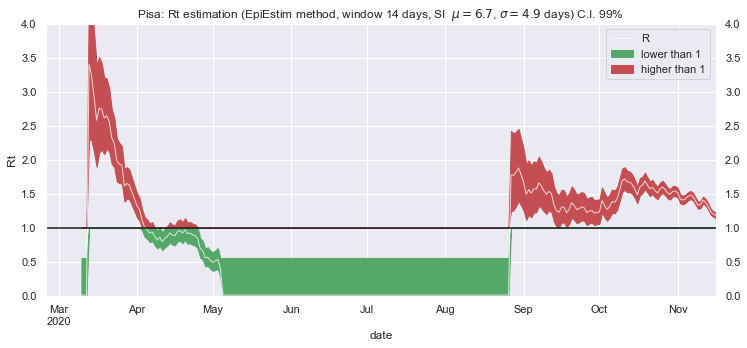

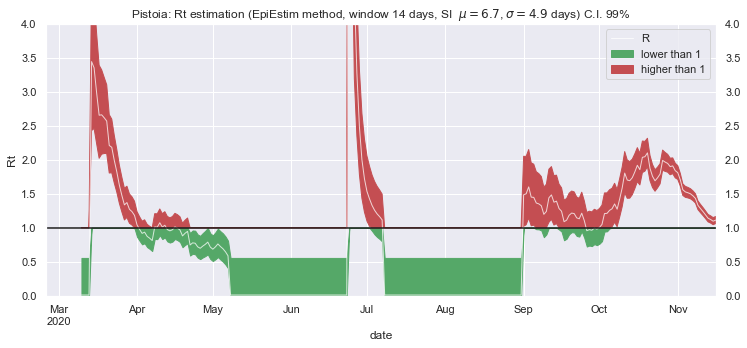

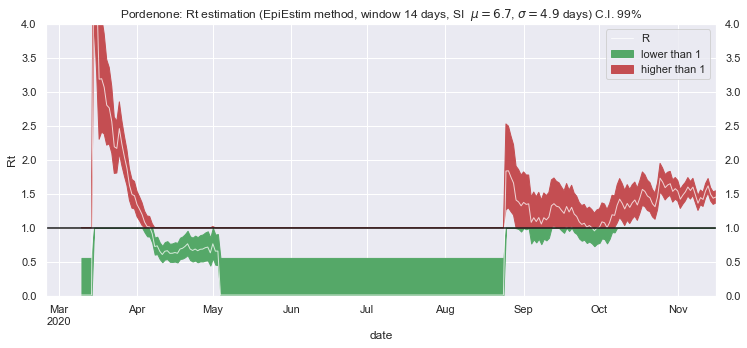

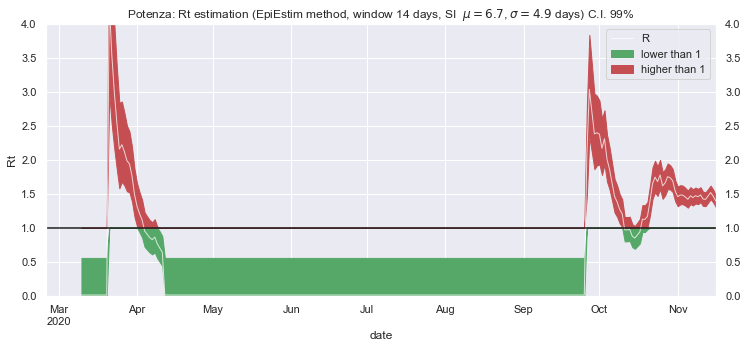

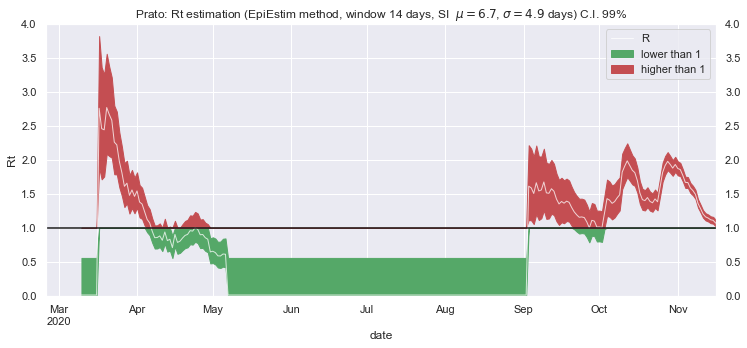

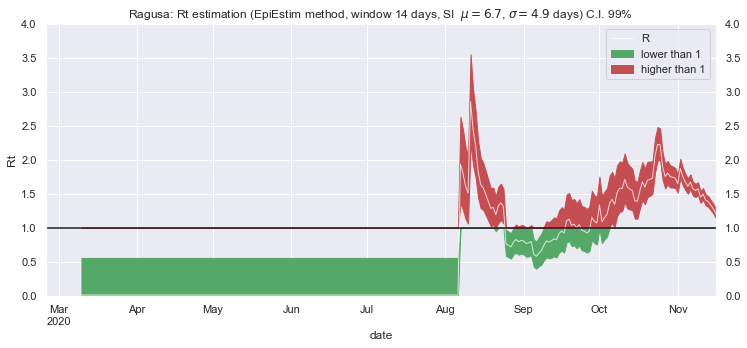

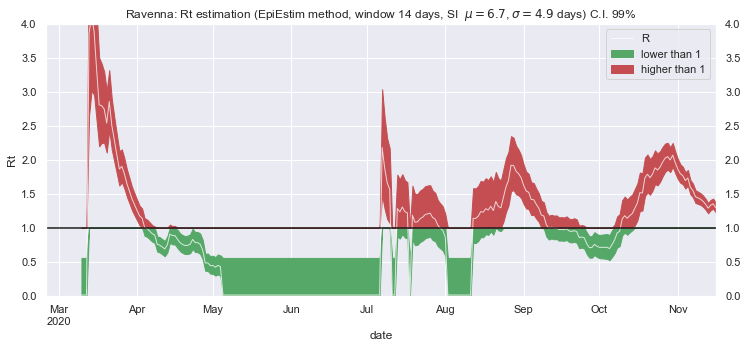

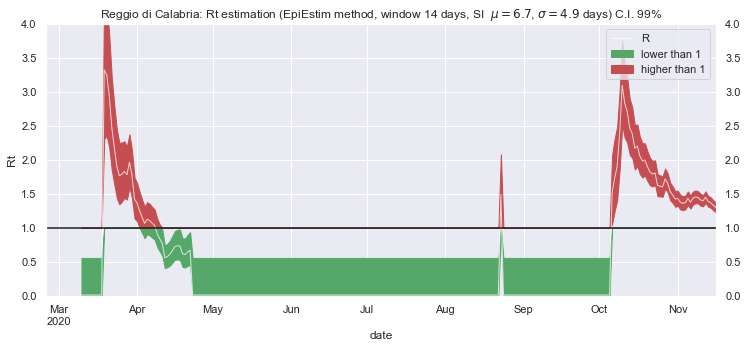

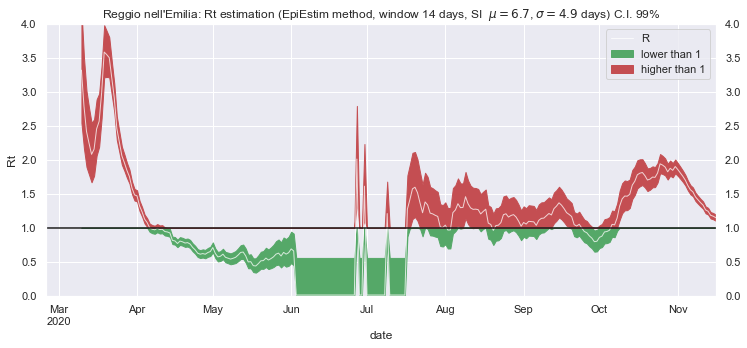

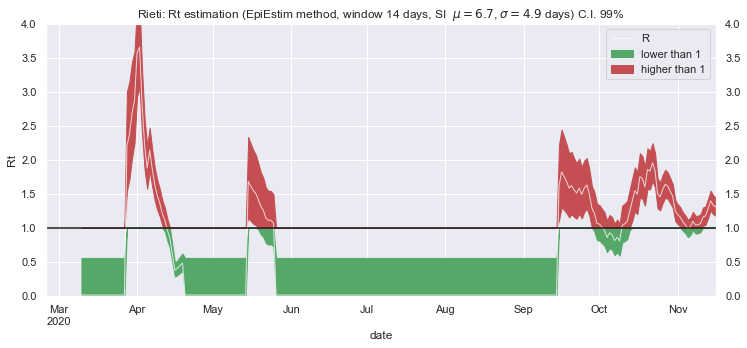

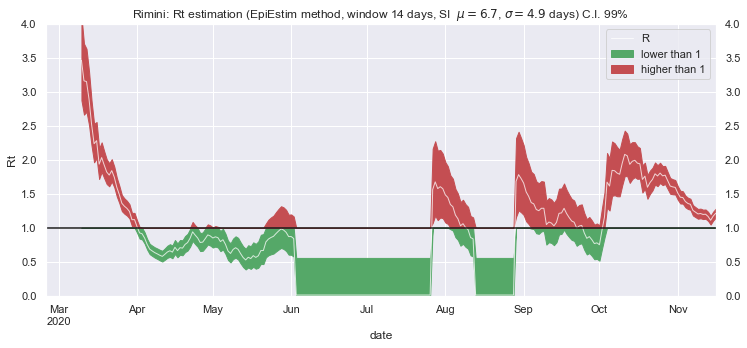

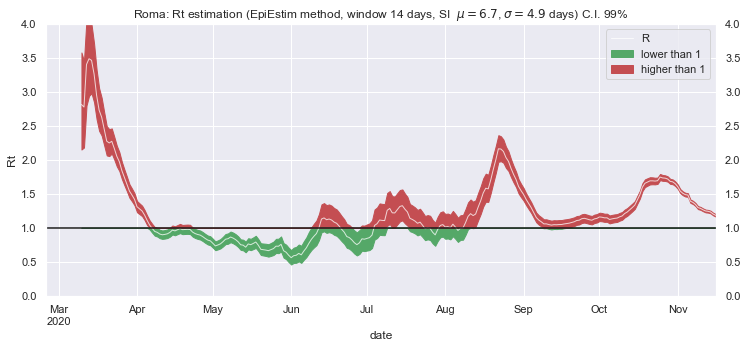

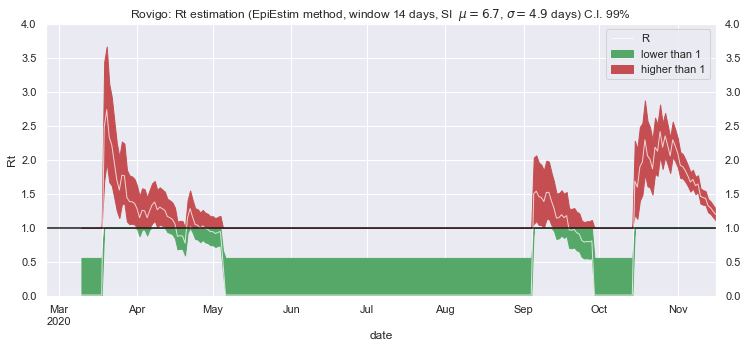

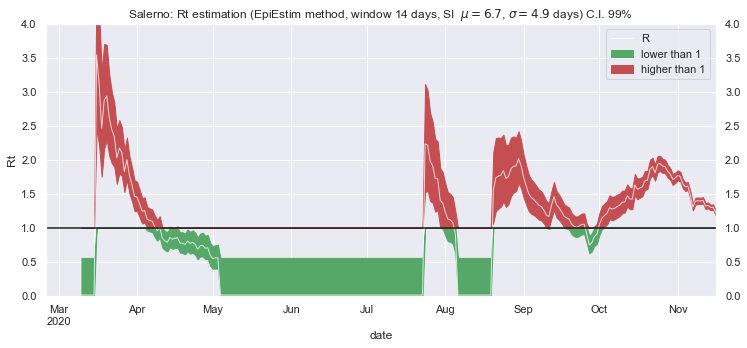

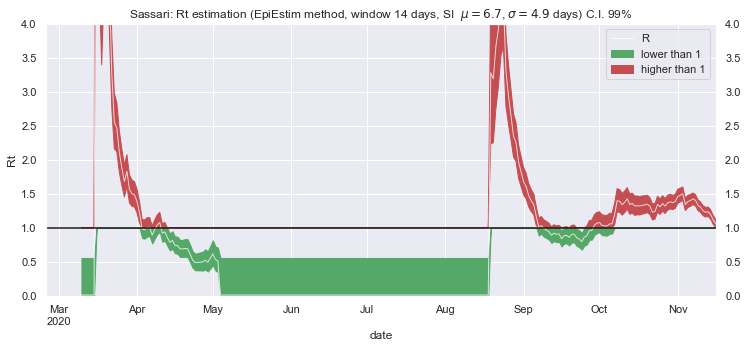

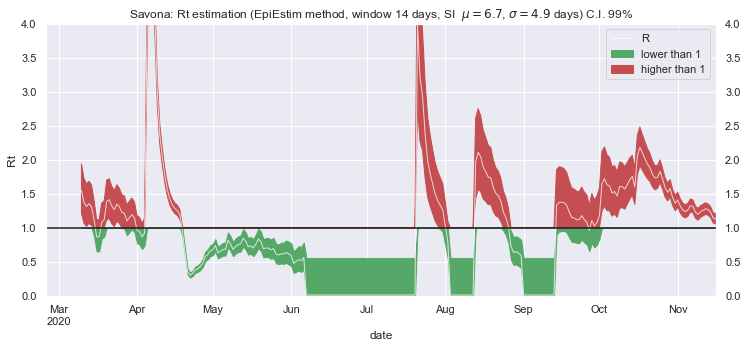

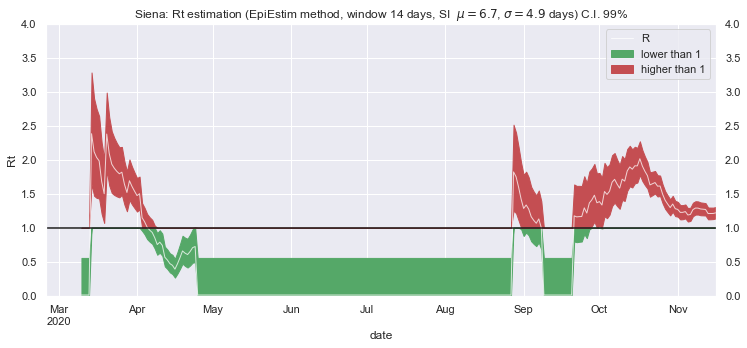

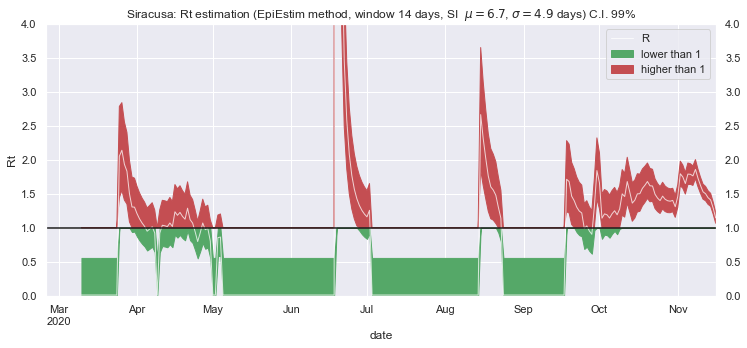

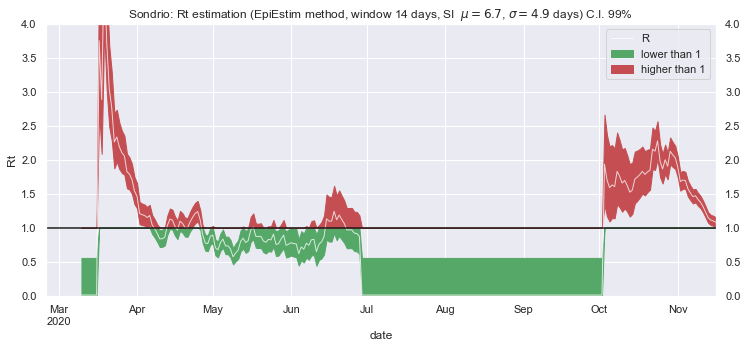

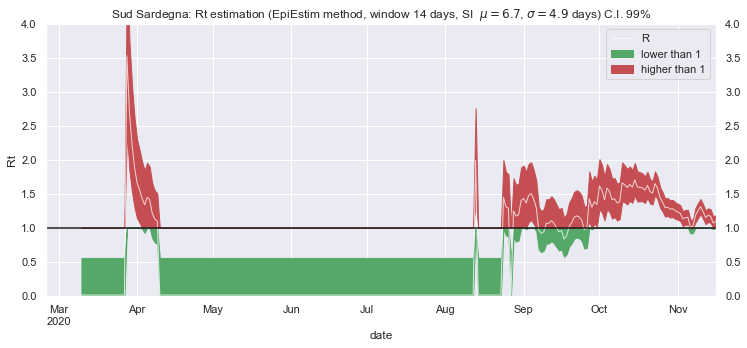

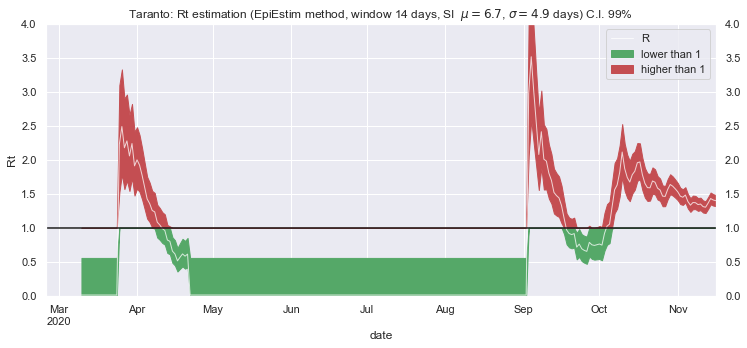

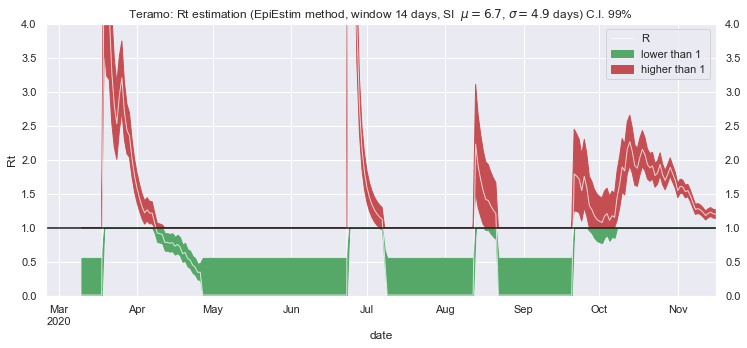

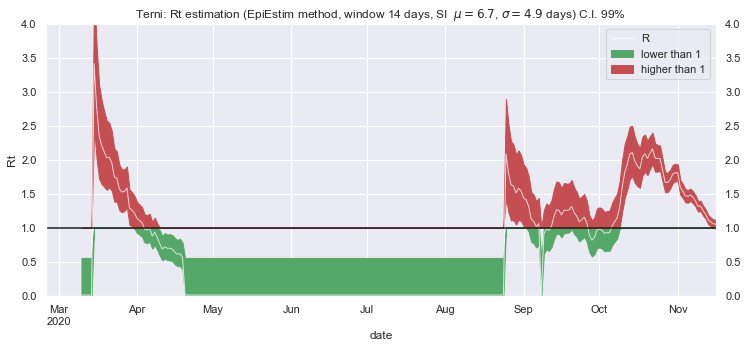

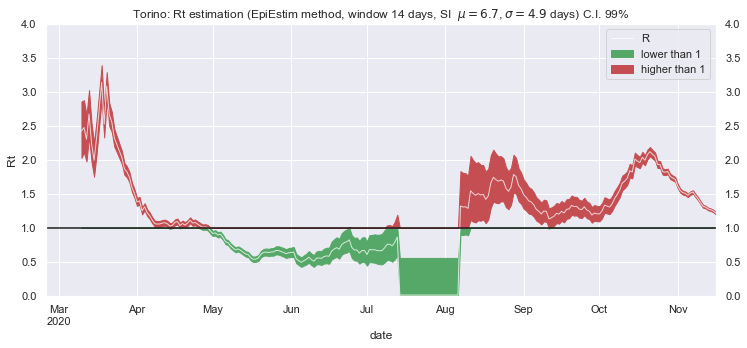

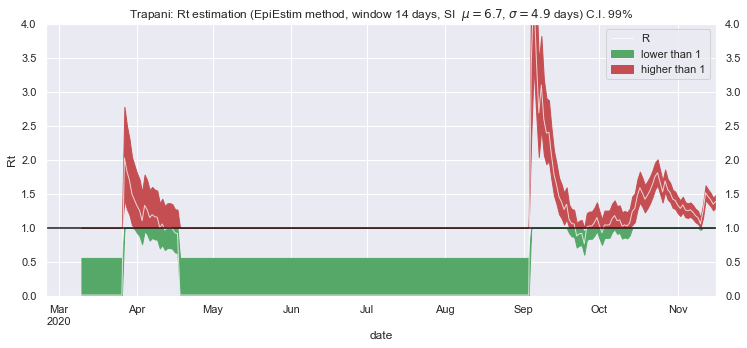

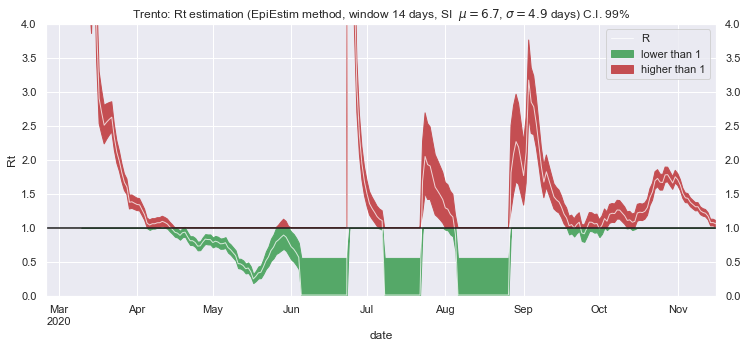

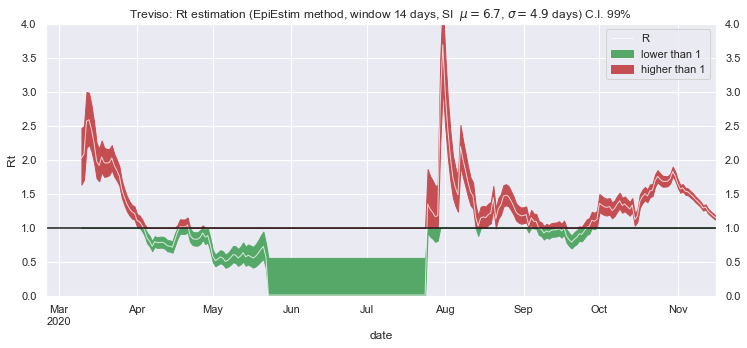

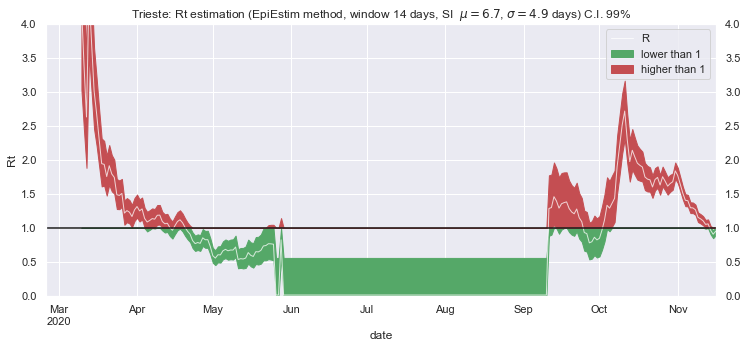

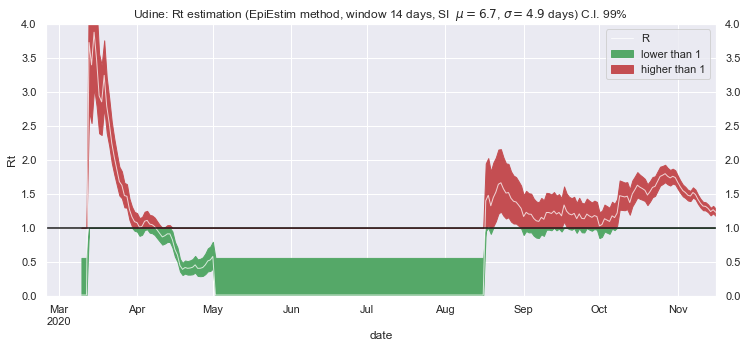

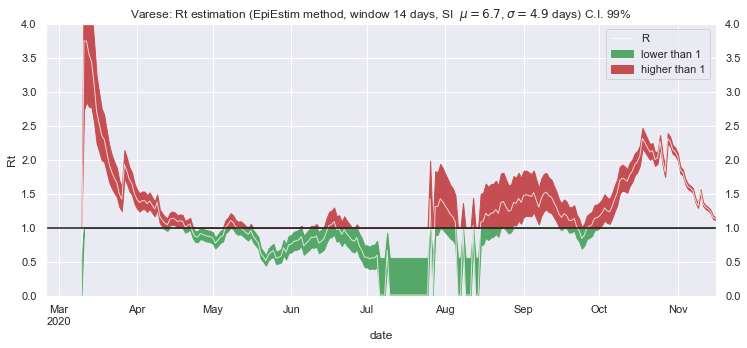

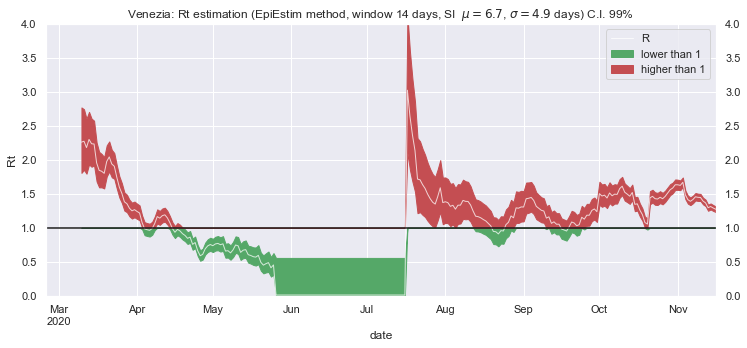

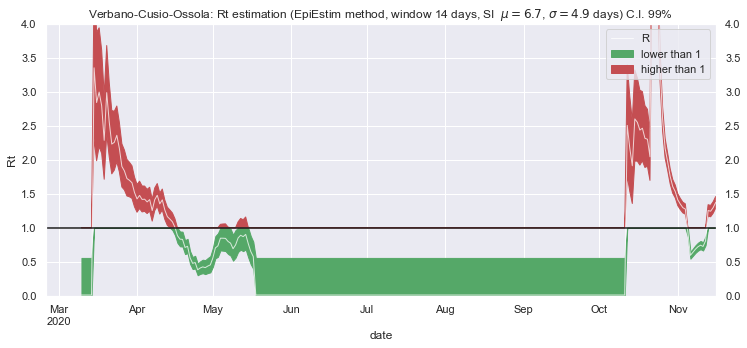

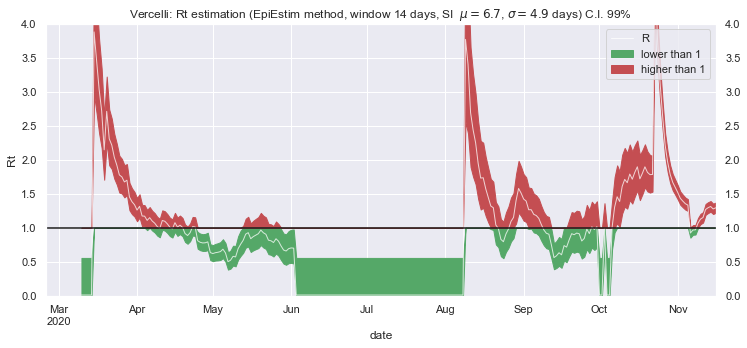

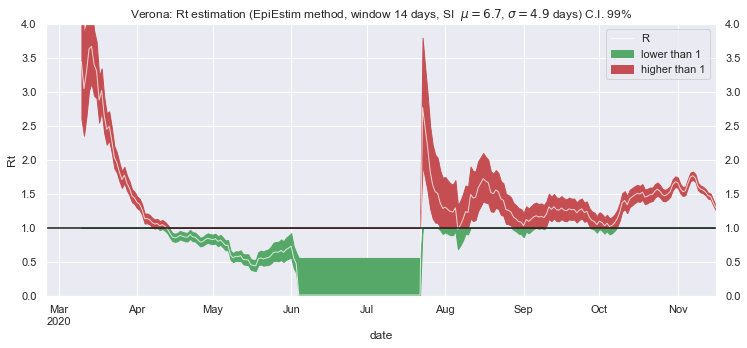

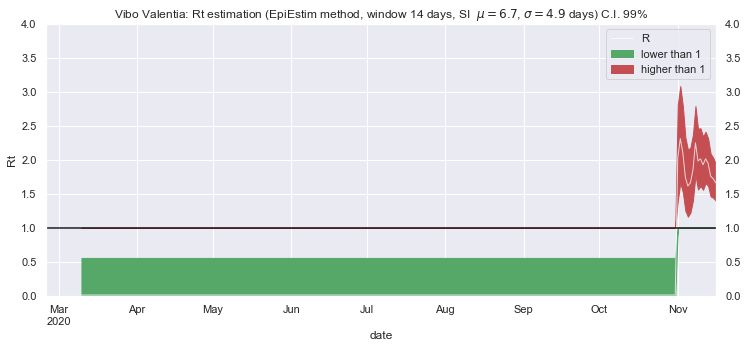

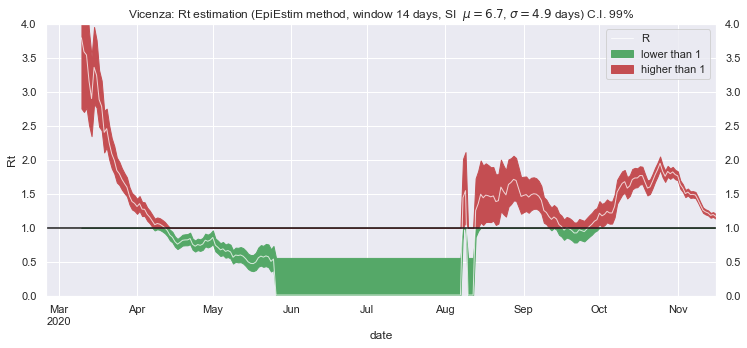

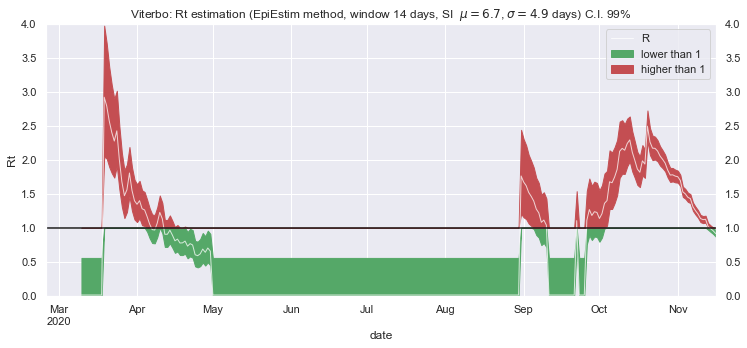

In [10]:
Rt_dict = {'provincia': [], 'mu': [], 'lo': [], 'hi': []}

for provincia in sorted(pro.denominazione_provincia.unique()):
    if 'definizione' in provincia or 'Fuori' in provincia:
        continue
    
    _df = pro[pro.denominazione_provincia==provincia]

    T = _df.index.size
    incidence = _df[['totale_casi']].diff().set_index(_df.data)[1:].copy(deep=True)
    
    incidence.loc[incidence.totale_casi<0, 'totale_casi'] = np.nan

    incidence.fillna(method='ffill', inplace=True)
    
    R = epi_estim_Rt(
        incidence, 
        SI_sh=SI_sh_ISS, SI_ra=SI_ra_ISS, 
        title=provincia
    )
    
    Rt_dict['provincia'].append(provincia)
    Rt_dict['mu'].append(R.R.iloc[-1])
    Rt_dict['lo'].append(R['q_0.50%'].iloc[-1])
    Rt_dict['hi'].append(R['q_99.50%'].iloc[-1])

# Sommario

In [11]:
Rt_df = pd.DataFrame(Rt_dict)

In [12]:
for p in Rt_df.provincia.unique():

    Rt_df.loc[Rt_df.provincia==p,'stato'] =\
    '>>1' if Rt_df[Rt_df.provincia==p].lo.iloc[0] > 1.5 else\
    '> 1' if Rt_df[Rt_df.provincia==p].lo.iloc[0] > 1 else\
    '< 1' if Rt_df[Rt_df.provincia==p].hi.iloc[0] < 1 else\
    '~ 1'

[(0.0, 3.0), Text(0, 0.5, '')]

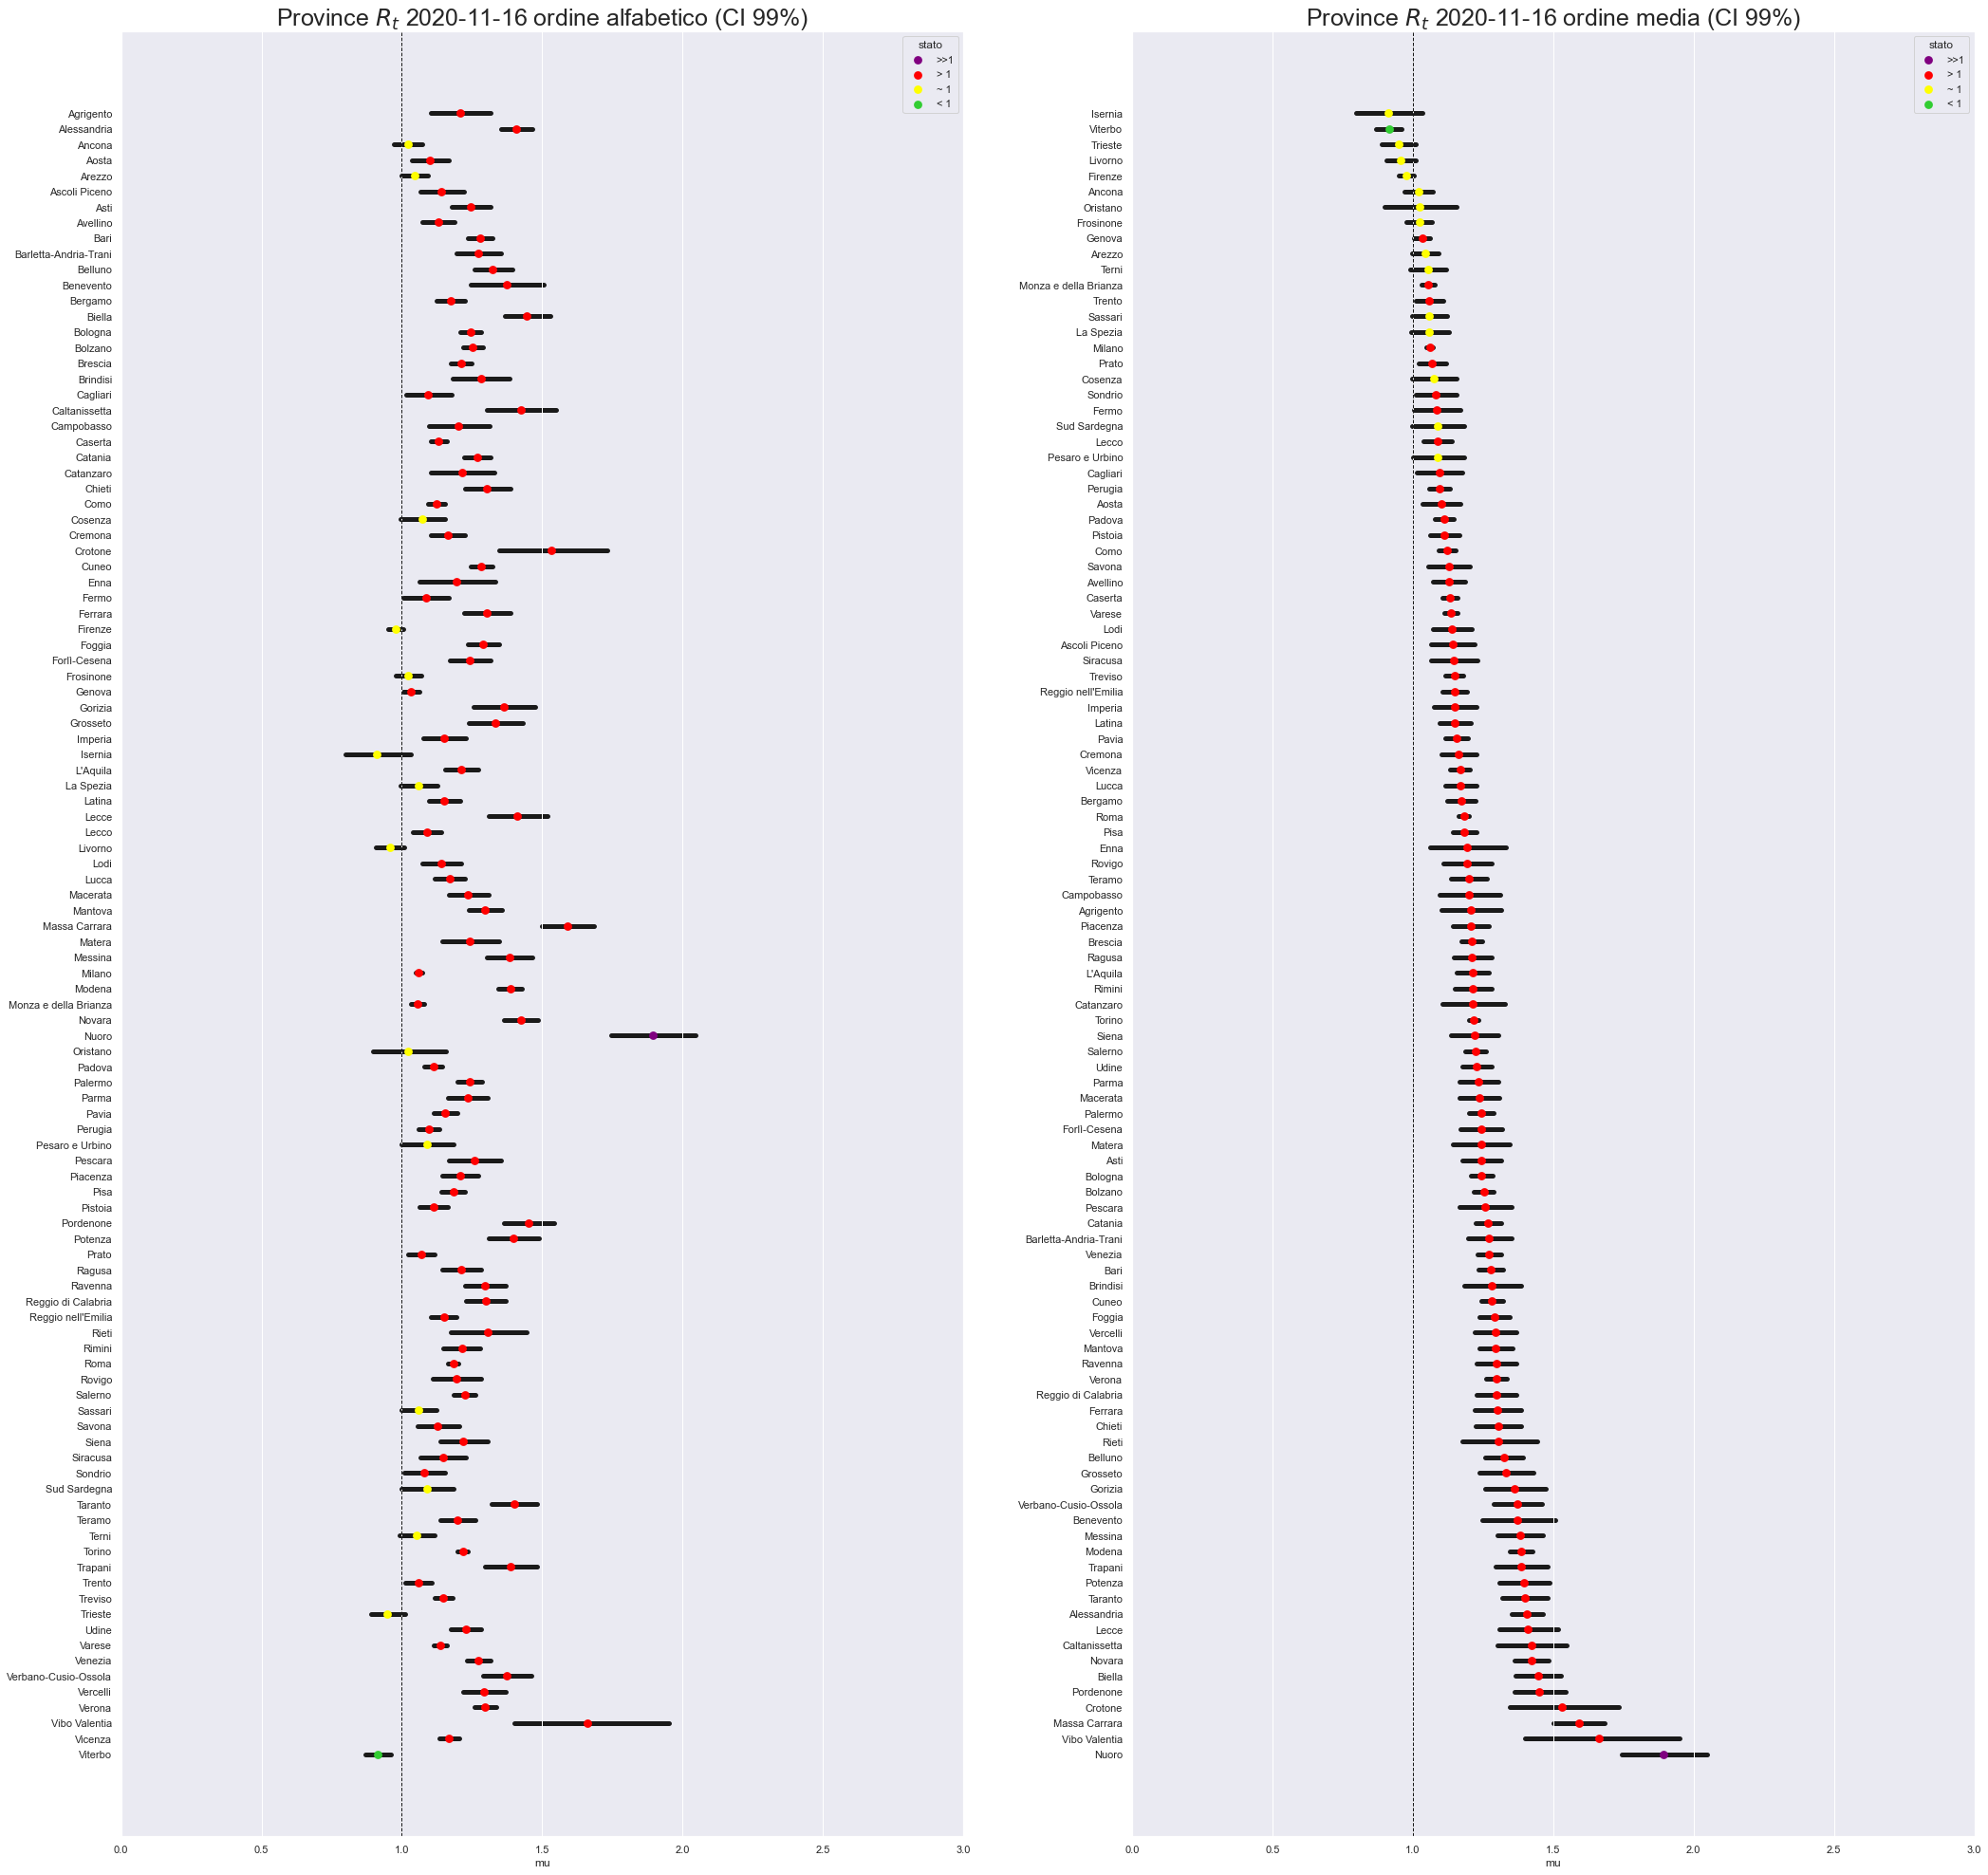

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(35, 35))

sns.pointplot(
    data=Rt_df,
    y='provincia', x='mu',
    hue='stato',
    join=False,
    hue_order=['>>1', '> 1', '~ 1', '< 1'],
    palette=['purple', 'red', 'yellow', 'limegreen'],
    ax=ax[0]
)

for provincia in Rt_df.provincia:
    _df = Rt_df[Rt_df.provincia==provincia]
    ax[0].plot(
        [_df.lo, _df.hi], [provincia, provincia],
        color='k', lw=5,
        zorder=0
    )
ax[0].axvline(1, color='k', ls='--', lw=1)
ax[0].set_title(f"Province $R_t$ {pro['data'].max().date()} ordine alfabetico (CI 99%)", fontsize=25)
ax[0].set(
    xlim=(0, np.ceil(Rt_df.hi.max())),
    ylabel=None
)


sns.pointplot(
    data=Rt_df.sort_values(by='mu'),
    y='provincia', x='mu',
    hue='stato',
    join=False,
    hue_order=['>>1', '> 1', '~ 1', '< 1'],
    palette=['purple', 'red', 'yellow', 'limegreen'],
    ax=ax[1]
)

for provincia in Rt_df.sort_values(by='mu').provincia:
    _df = Rt_df[Rt_df.provincia==provincia]
    ax[1].plot(
        [_df.lo, _df.hi], [provincia, provincia],
        color='k', lw=5,
        zorder=0
    )
ax[1].axvline(1, color='k', ls='--', lw=1)
ax[1].set_title(f"Province $R_t$ {pro['data'].max().date()} ordine media (CI 99%)", fontsize=25)
ax[1].set(
    xlim=(0, np.ceil(Rt_df.hi.max())),
    ylabel=None
)


# Mappa

Nota metodologica:

- se l'intervallo di credibilità è inferiore a 1, $R_t$ è significativamente minore di 1 (simbolo `<1`)
- se l'intervallo di credibilità comprende 1, $R_t$ non è significativamente diverso da 1 (simbolo `~1`)
- se l'intervallo di credibilità è maggior di 1 e minore di 1.5, $R_t$ è significativamente compreso tra 1 e 1.5 (simbolo `>1`)
- se l'intervallo di credibilità è superiore a 1.5, $R_t$ è significativamente maggiore di 1.5 (simbolo `>>1`)

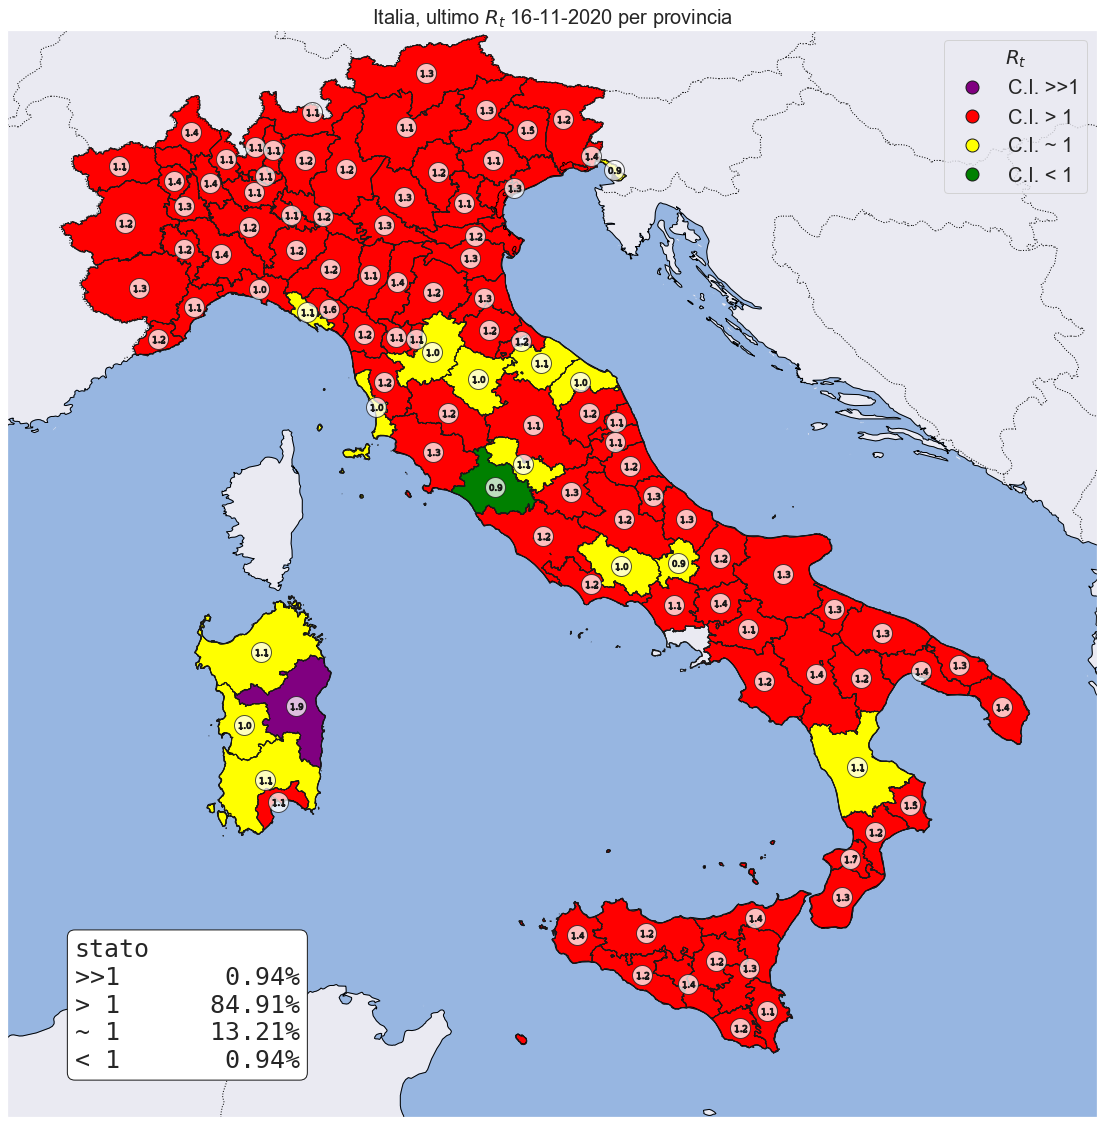

In [14]:
scatter_colors = {
    '>>1': 'purple',
    '> 1': 'red',
    '~ 1': 'yellow',
    '< 1': 'green'
}

Rt_df['color'] = Rt_df.stato.map(scatter_colors)

with open('province.geojson', 'r') as f:
    geo = json.load(f)

for feature in geo['features']:
    if feature['properties']['prov_name'] == "Valle d'Aosta/Vallée d'Aoste":
        feature['properties']['prov_name'] = 'Aosta'
    elif feature['properties']['prov_name'] == "Bolzano/Bozen":
        feature['properties']['prov_name'] = 'Bolzano'
    elif feature['properties']['prov_name'] == "Massa-Carrara":
        feature['properties']['prov_name'] = 'Massa Carrara'
    else:
        continue

def list_loop(ax, ls, col):
    try:
        poly = Polygon(ls)
        poly_patch = PolygonPatch(poly, color=col, transform=ccrs.PlateCarree(), ec='k')
        ax.add_patch(poly_patch, )
    except Exception as err:
        #print(err)
        for el in ls:
            list_loop(ax, el, col)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_extent((6, 19, 36, 47))

#ax.stock_img()
ax.coastlines()

for prov in Rt_df.provincia.unique():
    #print(prov)
    prov_name = None
    for i, feature in enumerate(geo['features']):
        if prov == feature['properties']['prov_name']:
            prov_name = feature['properties']['prov_name']
            break
    if prov_name is None:
        print(prov)
        continue

    lat = pro[pro.denominazione_provincia==prov].lat.unique()[0]
    lon = pro[pro.denominazione_provincia==prov].long.unique()[0]
    if prov == 'Messina':
        lon -= .25
    if prov == 'Prato':
        lat += .1
        lon += .1
    Rt_df.loc[Rt_df.provincia==prov, 'latitudine'] = lat
    Rt_df.loc[Rt_df.provincia==prov, 'longitudine'] = lon
    col = Rt_df[Rt_df.provincia==prov].color.unique()[0]
    
    coo = geo['features'][i]['geometry']['coordinates']
    
    list_loop(ax, coo, col)
    
    if len(coo[0]) < 10:
        poly = Polygon(coo[0][0])
    else:
        poly = Polygon(coo[0])
    
    Rt = Rt_df.loc[Rt_df.provincia==prov]['mu'].iloc[0]
    #print(lat, lon)
    
    centr = poly.centroid.coords.xy
    _lon = centr[0]
    _lat = centr[1]
    if prov == 'Vercelli':
        _lat = _lat[0] - .2
    
    ax.scatter(_lon, _lat, color='w', 
               s=400, edgecolors='k', 
               transform=ccrs.PlateCarree(), zorder=100,
               alpha=.75
              )
    
    ax.plot(
        _lon, _lat, marker=f'${Rt:.1f}$', ms=13, 
        color='k', 
        transform=ccrs.PlateCarree(),
        zorder=101,
    )
    #ax.text(
    #    lon, lat, f'${Rt:.1f}$', fontsize=8, color='w', transform=ccrs.PlateCarree(), ha='center', va='center',
    #    zorder=101
    #)

#ax.plot(-0.08, 51.53, 'o', transform=ccrs.PlateCarree())
#ax.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.PlateCarree())
#ax.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.Geodetic())

ax.add_feature(cfeat.BORDERS, linestyle=':')
ax.add_feature(cfeat.OCEAN)

fname = 'province-polygon.shp'
shape_feature = cfeat.ShapelyFeature(
    Reader(fname).geometries(),
    ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax.add_feature(shape_feature)
#ax.add_feature(cfeat.LAND)

stato = Rt_df.groupby('provincia')[['stato']].agg(lambda x: x.value_counts().index[0])
overview = (stato.value_counts() / Rt_df.index.size * 100).round(2).astype(str).agg(lambda x: f'{x}%').reindex(
    [
        ('>>1',),
        ('> 1',),
        ('~ 1',),
        ('< 1',)
    ]
).to_string()

ax.text(
    6.5, 36.5,
    overview,
    fontsize=25, fontfamily='monospace',
    ha='left',
    transform=ccrs.PlateCarree(),
    bbox=dict(boxstyle="round",
           ec='k',
           fc='w',
           )
)

ax.set_title(f'Italia, ultimo $R_t$ {pro["data"].max().date().strftime("%d-%m-%Y")} per provincia', fontsize=20)
legend_elements = [
    Line2D([0], [0], marker='o', color='k', label='C.I. >>1', markerfacecolor='purple', markersize=13, lw=0),
    Line2D([0], [0], marker='o', color='k', label='C.I. > 1', markerfacecolor='red', markersize=13, lw=0),
    Line2D([0], [0], marker='o', color='k', label='C.I. ~ 1', markerfacecolor='yellow', markersize=13, lw=0),
    Line2D([0], [0], marker='o', color='k', label='C.I. < 1', markerfacecolor='green', markersize=13, lw=0),
]
ax.legend(title="$R_t$", handles=legend_elements, loc='upper right', fontsize=20, title_fontsize=20)

#fig.tight_layout()
fig.set_facecolor('#00000000')
fig.savefig('rt-province-mappa.png', dpi=250)
plt.show()